# App Identification

Investagation 


IMPORTANT: Make sure to pass the argument `REBUILD=True` in `evalute` if this is the first time you run this jupyter notebook

<a id='tc'></a>
## Table of content 

**PART I** - Introduction and setup 

0. [Introduction](#intro)
1. [Setup](#setup)
    1. [Imports](#imports)
    2. [helpers](#helpers)
    3. [evaluation](#evaluation)

**PART II** - data exploration

2. [Banned App](#banned_app)
3. Dataset size investigation
4. Outliers

**PART III** - model evaluation and Performance
5. [Build/train/evaluate model](#evaluation)
    1. On Huawei
    2. On Fossil
    3. On actions
        - Max insuline can have... Need investigation
6. Dataset size effects on accuracy

**PART IV** - 2 axes Tranferability and elapsed time
7. [Transferability](#transferability)
 1. Extract common classes / evaluate both watches with the restricted dataset
 2. Mix both datasets (2 watches) and evaluate
 3. Keep only Huawei as train and test with Fossil
 4. Keep only Fossil as train and test with Huawei

**PART IV** - Impact on time
8. Separation of dataset by the date at which the capture has been performed




6. Outliers Detections


## PART I - Introduction and Setup

<a id='intro'></a>
## Introduction
Datasets: Automated Captures 

Classes: Apps are chosen from different metric based on:
    - confidentiallity: what an attacker would gain by knowing which apps a victim is using.
    - popularity: Based on famous reviews ore 
    - nativity: If the application is by default installed on the application

<a id='setup'></a>
## 1. Setup

<a id='imports'></a>
### imports

In [1]:
import pandas as pd
import numpy as np
import sys
import random
from build_datasets import *
import csv
import os
import pickle
import copy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle

### Helpers Functions
<a id='helpers'></a>

In [2]:
def merge_actions_in_app(events, to_merge):
    for actions in to_merge:
        events = merge_action_in_app(events, actions)
    return events


def merge_action_in_app(events, to_merge, separate_watch=True, maximum_level=None): # TODO separate watch
    """to_merge is of the form [app_feature_x1, app_feature_x2...]
    Cannot merge across apps
    """
    ## TODO: Make sure merge and 
    app = to_merge[0].split("_")[0]
    events_out = copy.deepcopy(events)
    to_merge_action_set = set([f.split("_")[1] for f in to_merge])
    print("to_merge_action_set = ", to_merge_action_set)
    for w in events:
        for appli in events[w]:
            if appli != app:
                continue
            merged_actions = []
            labeled_actions = ""
            for action in events[w][app]:
                if action in to_merge_action_set:
                    labeled_actions += action
                    merged_actions += events[w][app][action]
                    del events_out[w][app][action]
            events_out[w][app][labeled_actions] = merged_actions
    return events_out


def discard_actions(source_files, to_discard):
    sf_new = []
    for f in source_files:
        _in = False
        for df in to_discard:
            if df in f:
                _in = True
        if not _in:
            sf_new.append(f)
    return sf_new


def build_features_labels_dataset(events, adversary_capture_duration=-1):
    data = []
    labels = []
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration)
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)

    return data, labels


def separate_watch(events):
    """Separate events across datat"""
    
    if len(events.keys()) <= 1:
        print("Only 1 watch. Cannot separate")
        return events
    events_out = dict()
    
    all_devices = "-".join([device for device in events])
    events_out[all_devices] = dict()
    
    # dict init 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                    
                if not app in events_out[all_devices]:
                    events_out[all_devices][device+"_"+app] = dict()
                if not action in events_out[all_devices][device+"_"+app]:
                    events_out[all_devices][device+"_"+app][action] = events[device][app][action]
    return events_out


def delete_different_action_across_watch(events):
        # Create common action set if multiple watches
    intersection_set = set()
    for i, w in enumerate(events):
        all_action = []
        for app in events[w]:
            actions = set(events[w][app].keys())
            all_action += [app + "_" + act for act in actions]
        if i == 0:
            intersection_set = set(all_action)
        else:
            intersection_set = intersection_set.intersection(set(all_action))
    
    events_copy = copy.deepcopy(events)
    # Delete not common action from dictionnary
    for device in events_copy:
        for app in events_copy[device]:
            for action in events_copy[device][app]:
                if app + "_" + action not in intersection_set:
                    del events[device][app][action]
    return events


def equilibrate_events_across_apps_and_watch(events):
    """
    Equilibrate the events by identifing the minimum number of samples per class
    and discarding Randomly the extra samples present in the oder classes. 
    If there are multiple watchs, only the common application are kept

    Parameters: 
        events (dict[watch][app][action] -> event): dataset 

    Returns: 
        events (dict[watch][app][action] -> event): equilibrate dataset
    """
    
    events = delete_different_action_across_watch(events)
    print()
    print("After deleting")
    count_print(events)
    
    # Find minimum samples 
    counts = dict()
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                counts[device + "_" + app +"_" + action] = 0
            for action in events[device][app]:
                counts[device + "_" + app + "_" + action] += len(events[device][app][action])

    if len(counts.values())== 0:
        return events
    
    print("counts:")
    print(counts)

    nb_samples_per_cat = min(counts.values())
    print("nb_samples_per_cat=", nb_samples_per_cat)

    events_out = dict()

    # remove everything above the min across devices
    for device in events:
        for app in events[device]:

            for action in events[device][app]:

                if not device in events_out:
                    events_out[device] = dict()
                if not app in events_out[device]:
                    events_out[device][app] = dict()
                if not action in events_out[device][app]:
                    events_out[device][app][action] = random.sample(events[device][app][action], k=nb_samples_per_cat)

    counts = dict()
    for device in events_out:
        for app in events_out[device]:
            if not app in counts:
                counts[app] = 0
            for action in events_out[device][app]:
                counts[app] += len(events_out[device][app][action])

    return events_out, nb_samples_per_cat



def create_sub_dataset(datasets, N_TO_PICK = -1, AppToKeepOnly="all"):
    datasets_to_analysis = []
    labels_to_analysis = []

    for watch in datasets:
        for app in datasets[watch]:
            if AppToKeepOnly != "all" and app not in AppToKeepOnly:
                continue
            for action in datasets[watch][app]:
                label= WATCH_NAME +"_"+app+"_"+action


                events = datasets[watch][app][action]
                chosen_events = []
                if type(datasets[watch][app][action]) is dict:
                    events = list(events.keys())

                if N_TO_PICK == -1 or len(events) < N_TO_PICK:
                    chosen_events = random.sample(events, len(events_nb))
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    chosen_events = random.sample(events, N_TO_PICK)

                if type(datasets[watch][app][action]) is dict:
                    labels_to_analysis += [label + "_" + nb for nb in chosen_events]
                    datasets_to_analysis += [datasets[watch][app][action][event_nb] for event_nb in chosen_events]
                else:
                    labels_to_analysis += [label for nb in chosen_events]
                    datasets_to_analysis += events

    return datasets_to_analysis, labels_to_analysis


def extract_features(xy, capture_duration_does_nothing=0): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if y != 0])
    stats("outgoing", [abs(y) for y in ys if y > 0])
    stats("incoming", [abs(y) for y in ys if y < 0])
    stats("outgoing_30", [abs(y) for y in take(ys) if y > 0])
    stats("incoming_30", [abs(y) for y in take(ys) if y < 0])

    f["total_payload"] = sum([abs(y) for y in ys])

    # statistics about timings
    x_deltas = []
    i = 1
    while i<len(xs):
        x_deltas.append(xs[i]-xs[i-1])
        i += 1

    stats("x_deltas", x_deltas)
    stats("x_deltas_30", take(x_deltas))

    # bursts

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(1,1005):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    for l in lengths:
        f['unique_lengths_'+str(l)] = lengths[l]
        
    return f


def filter_by_length(events, minimum_payload=200, ratio_app_not_satisfing_minimum_payload_length=0.25, printInfo = False):
    results = copy.deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                total_event = len(events[watch][app][action])
                bellow_minimum_payload = 0
                for sample in events[watch][app][action]:

                    payload_length = sum([abs(s) for s in sample["ys"]])
                    if payload_length < minimum_payload:
                        bellow_minimum_payload += 1

                ratio_bellow = bellow_minimum_payload / total_event
                if ratio_bellow > ratio_app_not_satisfing_minimum_payload_length:
                    if printInfo:
                        print("total_event: ", total_event, " - bellow threshold: ", bellow_minimum_payload)
                        print(app + "_" + action + " removed")
                        print(" ratio_below = ", ratio_bellow)
                    del results[watch][app][action]

            if len(results[watch][app]) == 0:
                del results[watch][app]
    return results


def plot_confusion_matrix(y_true, y_pred,
                          normalize=True,
                          title=True,
                          save = None, 
                         PLOT_DIR="./plots/"):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(20, 20), dpi= 180)
    ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")


    plt.savefig(PLOT_DIR+save)
    print("Saved image", PLOT_DIR+save+".png")

    return cm, fig, ax


def count_print(events):
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                print("{}: {}_{} - {}".format(d, app, act,  len(events[d][app][act])))

                
# Compute the mean over realisations
def plot_acc_and_conf(n_samples, accuracies, title, fname):
    n_samples = np.array(n_samples)
    accuracies = np.array(accuracies)


    n_samples_repr = n_samples.reshape((-1,repeat))[:,0]
    accuracies_repr = accuracies.reshape((-1,repeat)) * 100

    accuracies_avg = accuracies.reshape((-1,repeat)).mean(axis = 1) 
    accuracies_conf = accuracies.reshape((-1,repeat)).std(axis = 1) * 2 

    conf_upper = accuracies_avg + accuracies_conf
    conf_lower = accuracies_avg - accuracies_conf

    fig, ax = plt.subplots()
    ax.plot(n_samples_repr, accuracies_avg, '-b', label='Accuray')
    ax.plot(n_samples_repr, conf_upper, '--r', label='95% confidence interval')
    ax.plot(n_samples_repr, conf_lower, '--r')
    plt.title(title)
    ax.set_xlabel('number of estimator in the random forest (model complexity)')
    ax.set_ylabel('accuracy')
    leg = ax.legend()
    plt.savefig("./"+fname)


### Main function
<a id='evaluation'></a>
[Table of content](#tc)

In [3]:
def evaluate(DATA_PATH, DISCARDED_ACTION=[], TO_MERGE=[], EQUALIZATION=True,
             REBUILD=False, TEST_PERCENTAGE=0.25, MINIMUM_PAYLOAD=200, SHUFFLE=False,
             RATIO=0.25, N_SPLITS=50, N_ESTIMATOR=100, SEPARATE_WATCH=False,
             PRINT_COUNT=False, PLOT_DIR="./plots/", RETURN_PRED=False,
             RETURN_EQUILIBRATE_EVENTS=False, RETURN_FEATURES_AND_LABELS=False):
    
    print("\nimporting data...")
    sources_files = find_sources(DATA_PATH)


    if len(DISCARDED_ACTION) != 0:
        print("withdraw action to be discarded")
        sources_files = discard_actions(sources_files, DISCARDED_ACTION)


    if REBUILD:
        print("rebuilding dataset")
        rebuild_all_datasets(sources_files)

    events, counts = cut_all_datasets_in_events(sources_files)

    if len(TO_MERGE) != 0:
        print("merging events")
        events = merge_actions_in_app(events, TO_MERGE)


    print("filtering app that does not send traffic by their length")
    filtered_events = filter_by_length(events, minimum_payload=MINIMUM_PAYLOAD, ratio_app_not_satisfing_minimum_payload_length=RATIO)
    
    if PRINT_COUNT:
        print("\nclass event count")
        count_print(filtered_events)
        print()

    nb_samples_per_cat = "not uniform"
    if EQUALIZATION:
        print("dataset equalization per class")
        filtered_events, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events)
        
        if PRINT_COUNT:
            print("\nclass event count after equalization")
            count_print(filtered_events)
            print()
        if RETURN_EQUILIBRATE_EVENTS:
            return filtered_events
    
    if SEPARATE_WATCH:
        print("separate watch action")
        filtered_events = separate_watch(filtered_events)
        if print_count:
            print()
            count_print(filtered_events)


    print("building features and labels")
    X, y = build_features_labels_dataset(filtered_events)
    if RETURN_FEATURES_AND_LABELS:
        return X, y

    # ## Accuracy with cross validation

    print("building and training the model for cross validation ")
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=None)
    shuf_split = ShuffleSplit(n_splits=N_SPLITS, test_size=0.25, random_state=None)
    scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
    print("Random split cross-validation: Accuracy=%0.3f (+/- %0.2f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    eval_metric = "cross-val radomSplit={} accRs={:.1f} +-{:.1f}% 95% conf interval".format(N_SPLITS, scores_shuffle.mean() *100, scores_shuffle.std() * 2 * 100)

    # ### Plotting the confusion matrix

    print("building and training a model for confusion matrix")
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=None)


    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if RETURN_PRED:
        return y_test, y_pred
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("accuracy = ", accuracy)


    title = "Confusion matrix for {}acc={:0.2f} ".format("and ".join([f.replace("/", "_") for f in DATA_PATH]), accuracy * 100)
    title += eval_metric
    title += "test={}% minimum_payload={}B nb_samples={}".format(int(TEST_PERCENTAGE * 100), MINIMUM_PAYLOAD, nb_samples_per_cat)
    saved_title = title.replace(".", "_").replace(" ", "_")
    cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, save = saved_title, PLOT_DIR=PLOT_DIR)

    print("done")

<a id='banned_app'></a>
## Banned App 
[table of content](#tc)

App that was not considered because they did not send enough traffic at oppening (cut-off at 200B )

In [296]:
DATA_PATH = "data/huawei/open-3/"
sources_files = find_sources(DATA_PATH)
events, _ = cut_all_datasets_in_events(sources_files)
filtered_events = filter_by_length(events, minimum_payload=200, ratio_app_not_satisfing_minimum_payload_length=0.25)

filtered_events_set = set()
for w in filtered_events:
    s = set(filtered_events[w].keys())
    filtered_events_set = filtered_events_set.union(s)


event_set = set()
for w in events:
    event_set = event_set.union(set(events[w].keys()))

print("Apps that did not send enoughn information at opening: \n\n",event_set.difference(filtered_events_set))
print("\n",len(event_set.difference(filtered_events_set)), "/", len(event_set), " not consided")

Apps that did not send enoughn information at opening: 

 {'GooglePay', 'PlayMusic', 'ASB', 'DailyTracking', 'NoApp', 'Sleep', 'Alarm', 'HeartRate', 'AthkarOfPrayer', 'WearCasts', 'Workout', 'HealthyRecipes', 'Medisafe', 'Battery', 'Phone', 'Reminders', 'DuaKhatqmAlQuran', 'Flashlight'}

 18 / 56  not consided


We can group these applications that does not communicate into different groups:

The ones that does not communicate because we could not perform the login: 

It is the case for `GooglePay` and `ASB`:

- `GooglePay` because login requires to set a password on the watch which we do not want because of technicall reason, it is not suitable for automation. 

- `ASB` requires to have a home address in new-Zealand, which we do not have. 

The application that does not communicate at all:

- `Flashlight` is an application that only set the watch screen to white to increase the luminosity in the dark. It is obvious that this application does not need any connection with the phone and therefore 

- `Battery` gives information about the watch itself does not requie any external resources that the phone has but the watch does not.

The application that does not communicate at lanch time but when performing an action sends traffic:

- `Phone` does not need a sync with the phone at launch but when making a phone call sends traffic over bluetooth

- `HealthyRecepies` only generate traffic when 


## Build/train/evaluate model
[table of content](#tc)

### Huaweiwatch 2



importing data...
filtering app that does not send traffic by their length
dataset equalization per class

After deleting
LEO-BX9: Bring_open - 28
LEO-BX9: Calm_open - 29
LEO-BX9: ChinaDaily_open - 28
LEO-BX9: Citymapper_open - 28
LEO-BX9: DCLMRadio_open - 29
LEO-BX9: DiabetesM_open - 28
LEO-BX9: Endomondo_open - 28
LEO-BX9: FITIVPlus_open - 28
LEO-BX9: FindMyPhone_open - 28
LEO-BX9: FitBreathe_open - 28
LEO-BX9: FitWorkout_open - 28
LEO-BX9: Fit_open - 28
LEO-BX9: FoursquareCityGuide_open - 28
LEO-BX9: Glide_open - 28
LEO-BX9: KeepNotes_open - 28
LEO-BX9: Krone_open - 28
LEO-BX9: Lifesum_open - 28
LEO-BX9: MapMyRun_open - 28
LEO-BX9: Maps_open - 28
LEO-BX9: Meduza_open - 28
LEO-BX9: Mobilis_open - 28
LEO-BX9: Outlook_open - 28
LEO-BX9: PlayStore_open - 28
LEO-BX9: Running_open - 28
LEO-BX9: SalatTime_open - 28
LEO-BX9: Shazam_open - 28
LEO-BX9: SleepTracking_open - 28
LEO-BX9: SmokingLog_open - 27
LEO-BX9: Spotify_open - 28
LEO-BX9: Strava_open - 28
LEO-BX9: Telegram_open - 28
LEO-BX

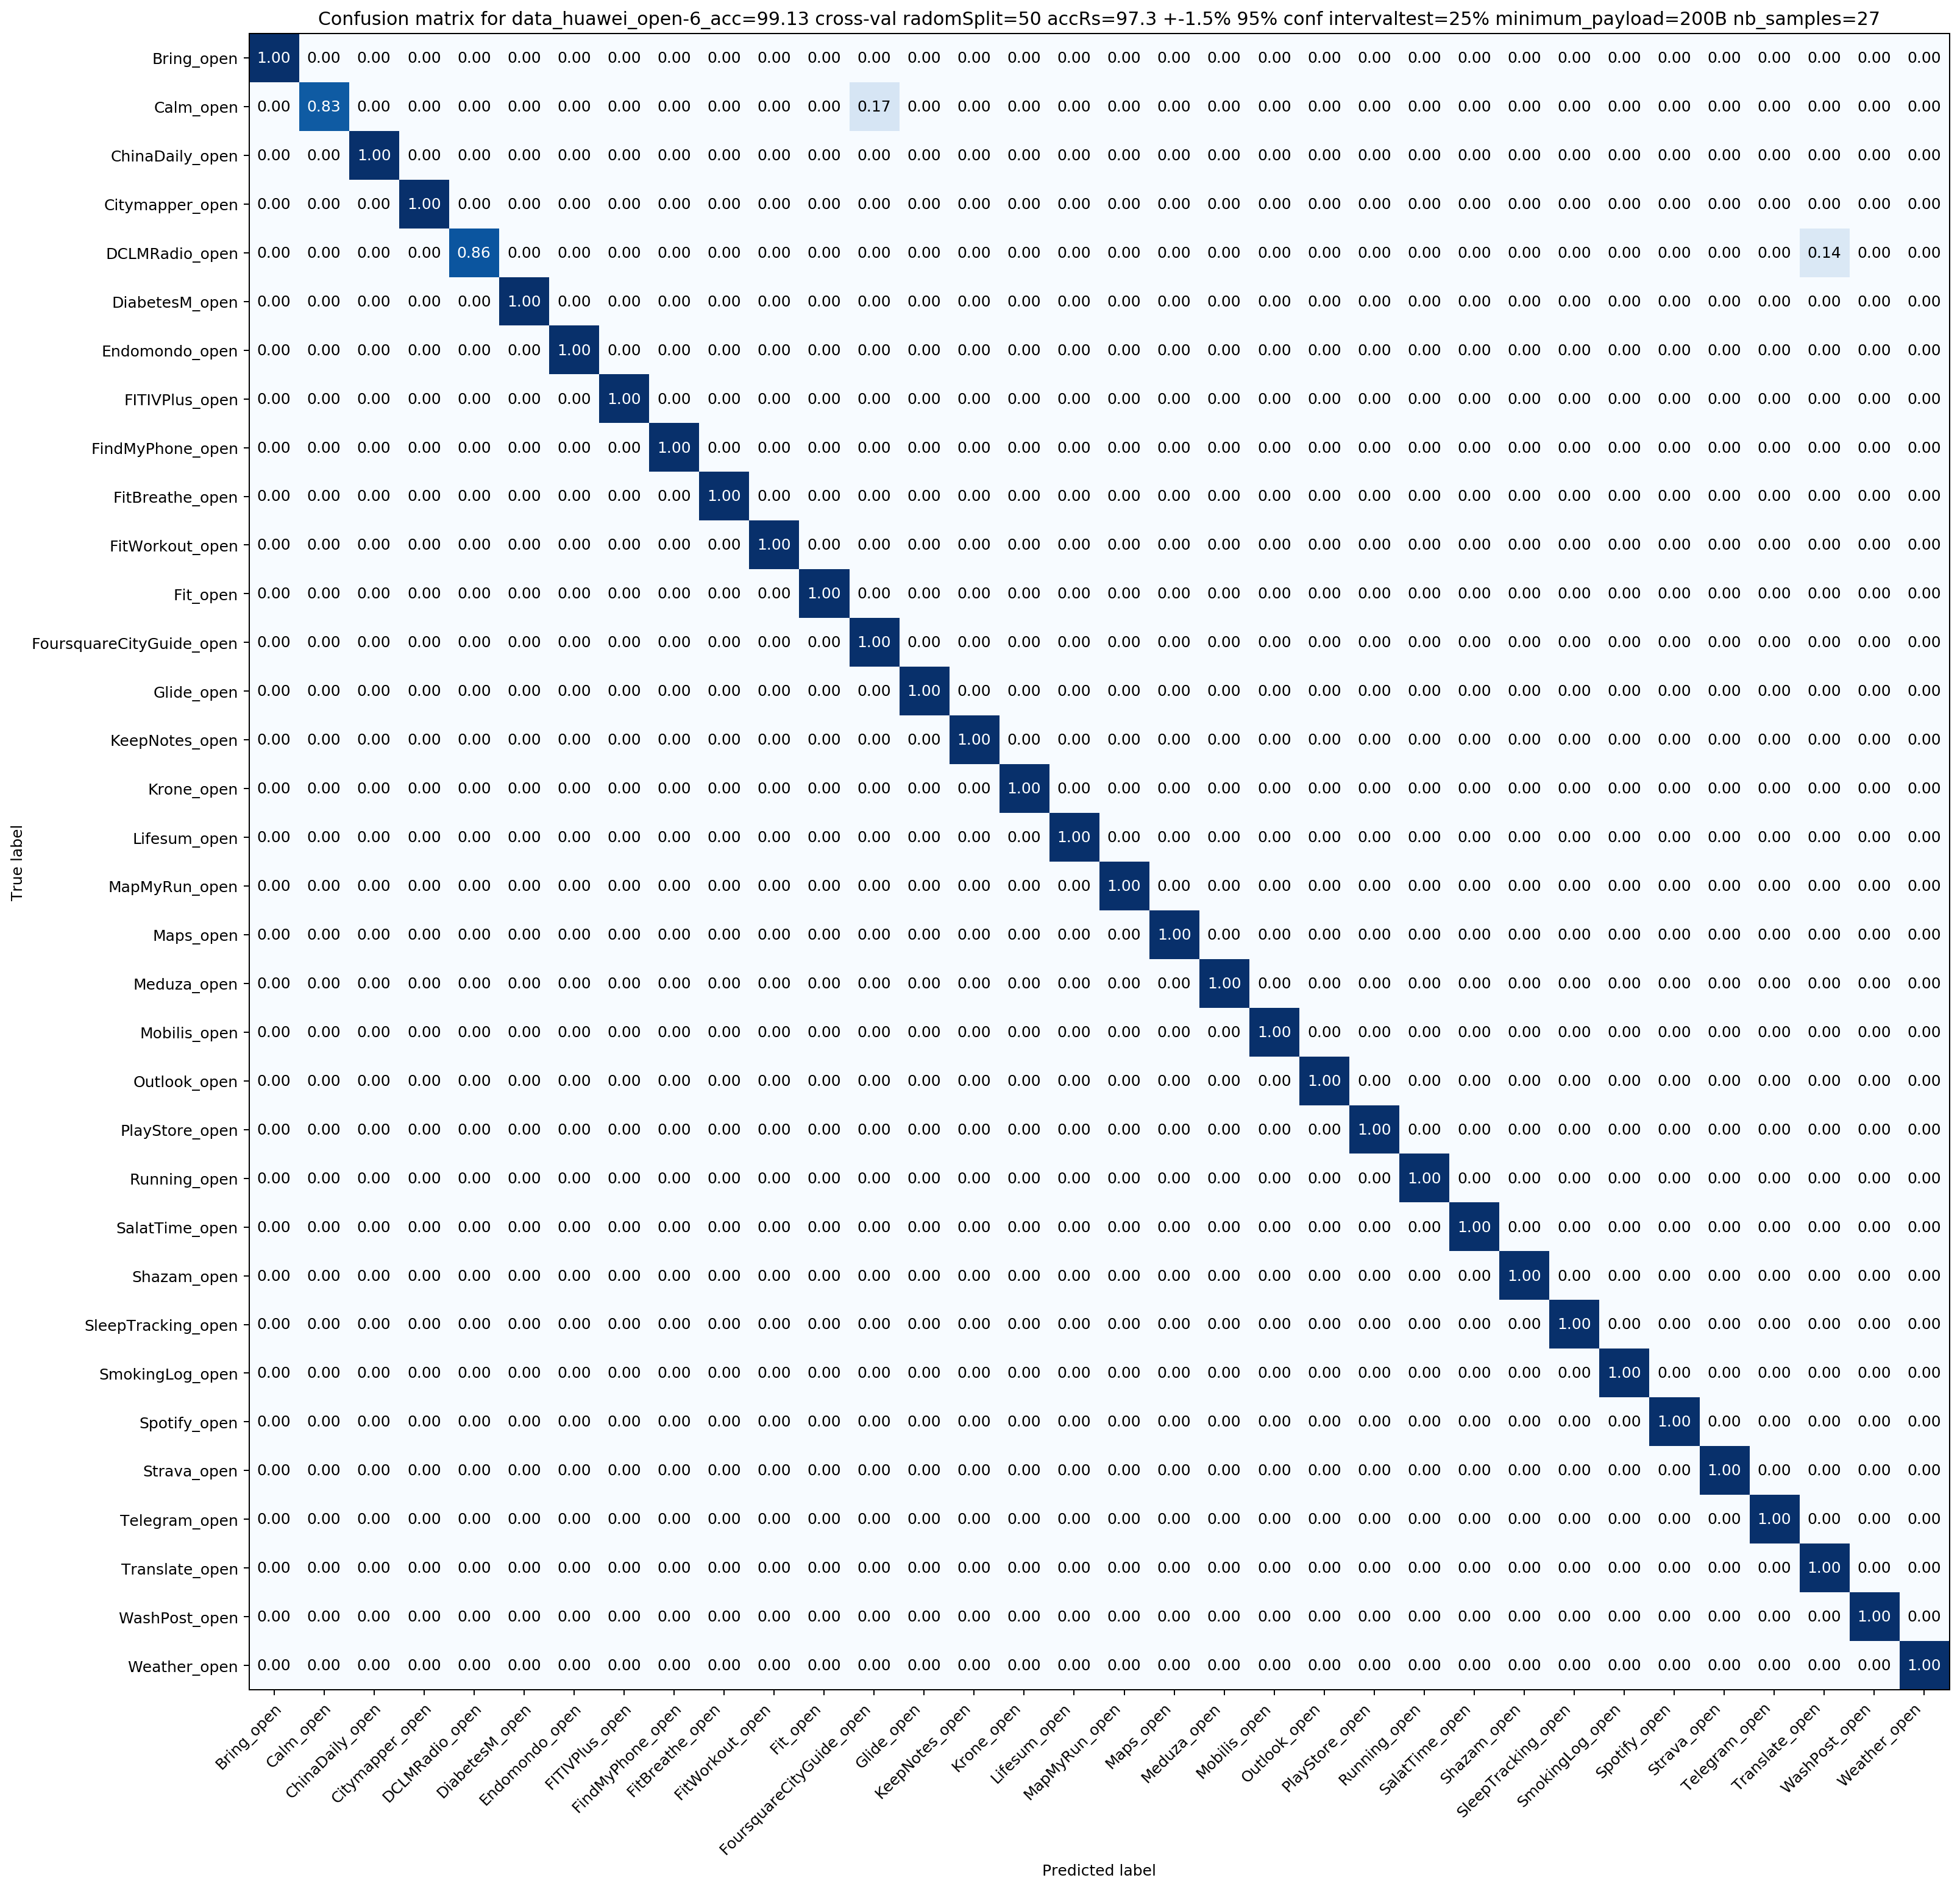

In [4]:
DATA_PATH = ["data/huawei/open-6/"] # all
evaluate(DATA_PATH, REBUILD=False)

### Fossil


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.913 (+/- 0.03). 
building and training a model for confusion matrix
accuracy =  0.919047619047619
Saved image ./plots/Confusion_matrix_for_data_fossil_open-6_acc=91_90_cross-val_radomSplit=50_accRs=91_3_+-3_4%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=24.png
done


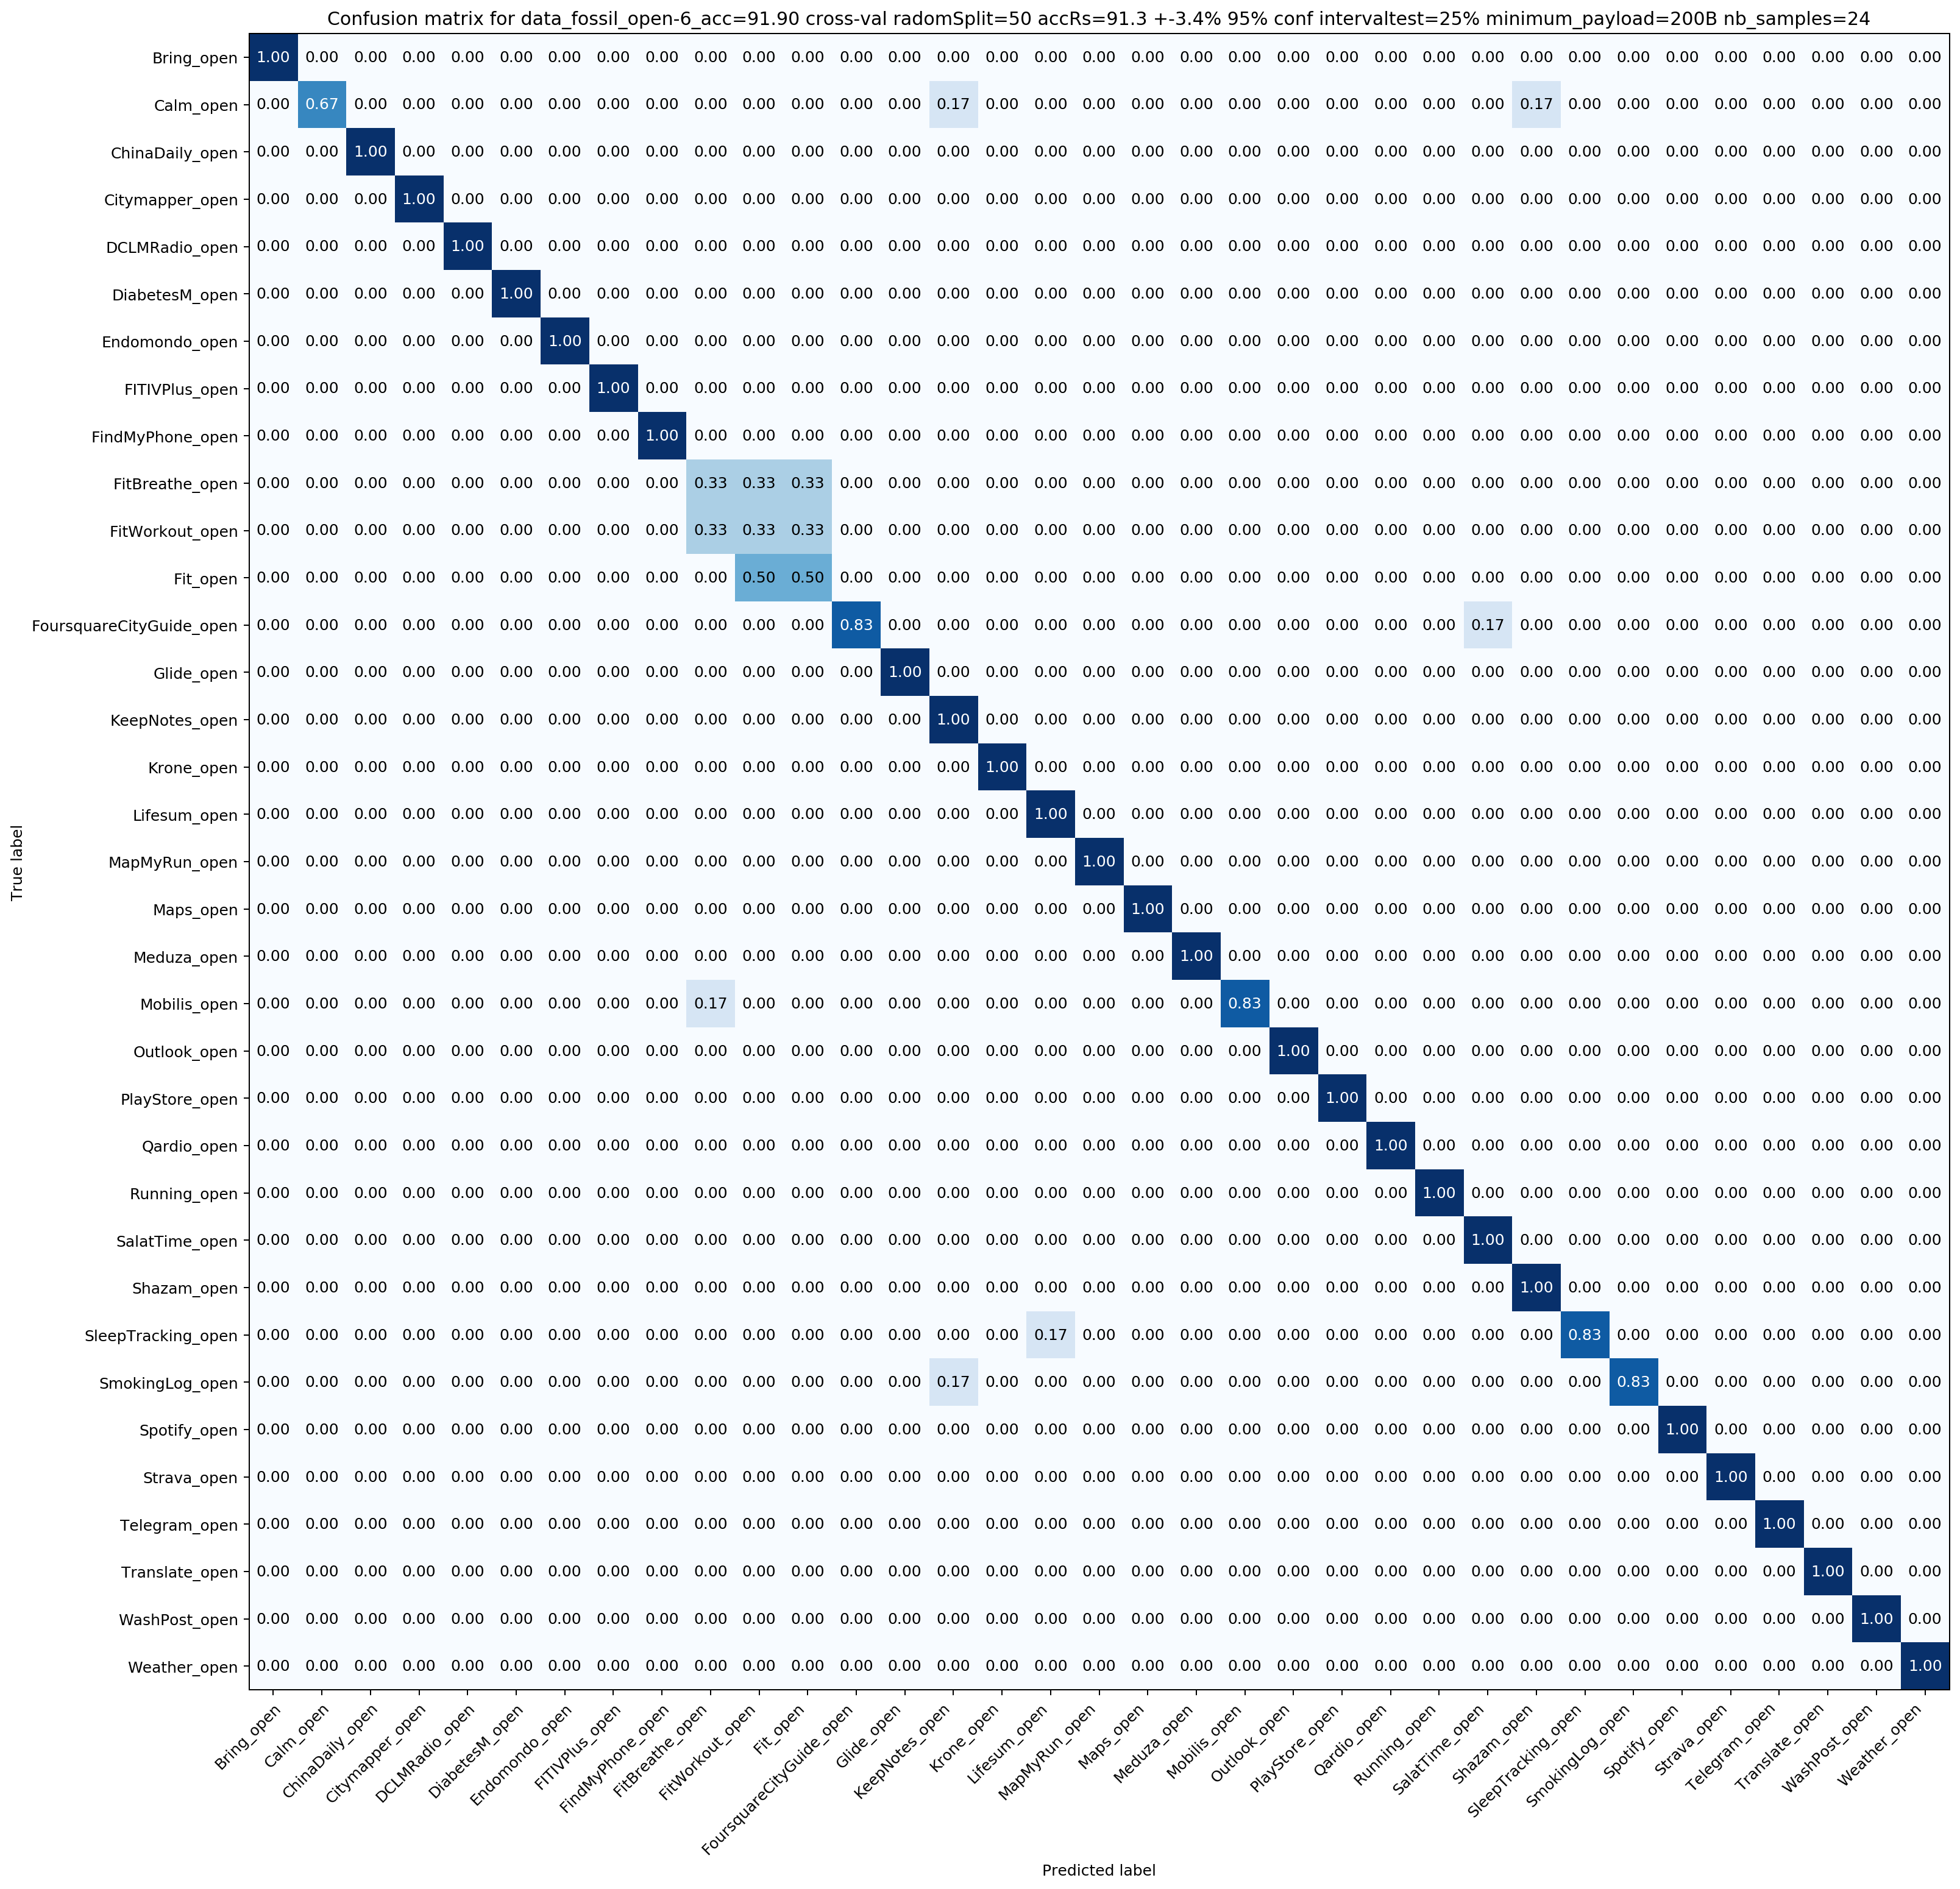

In [18]:
DATA_PATH = ["data/fossil/open-6/"] # all
evaluate(DATA_PATH)

### Actions
<a id='actions'></a>
#### DiabetesM
<a id='DiabetesM'></a>


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.433 (+/- 0.07). 
building and training a model for confusion matrix
accuracy =  0.40588235294117647
Saved image ./plots/Confusion_matrix_for_data_huawei_DiabetesM-1_and_data_huawei_DiabetesM-2_and_data_huawei_DiabetesM-3_and_data_huawei_DiabetesM-4_acc=40_59_cross-val_radomSplit=50_accRs=43_3_+-7_1%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=113.png
done


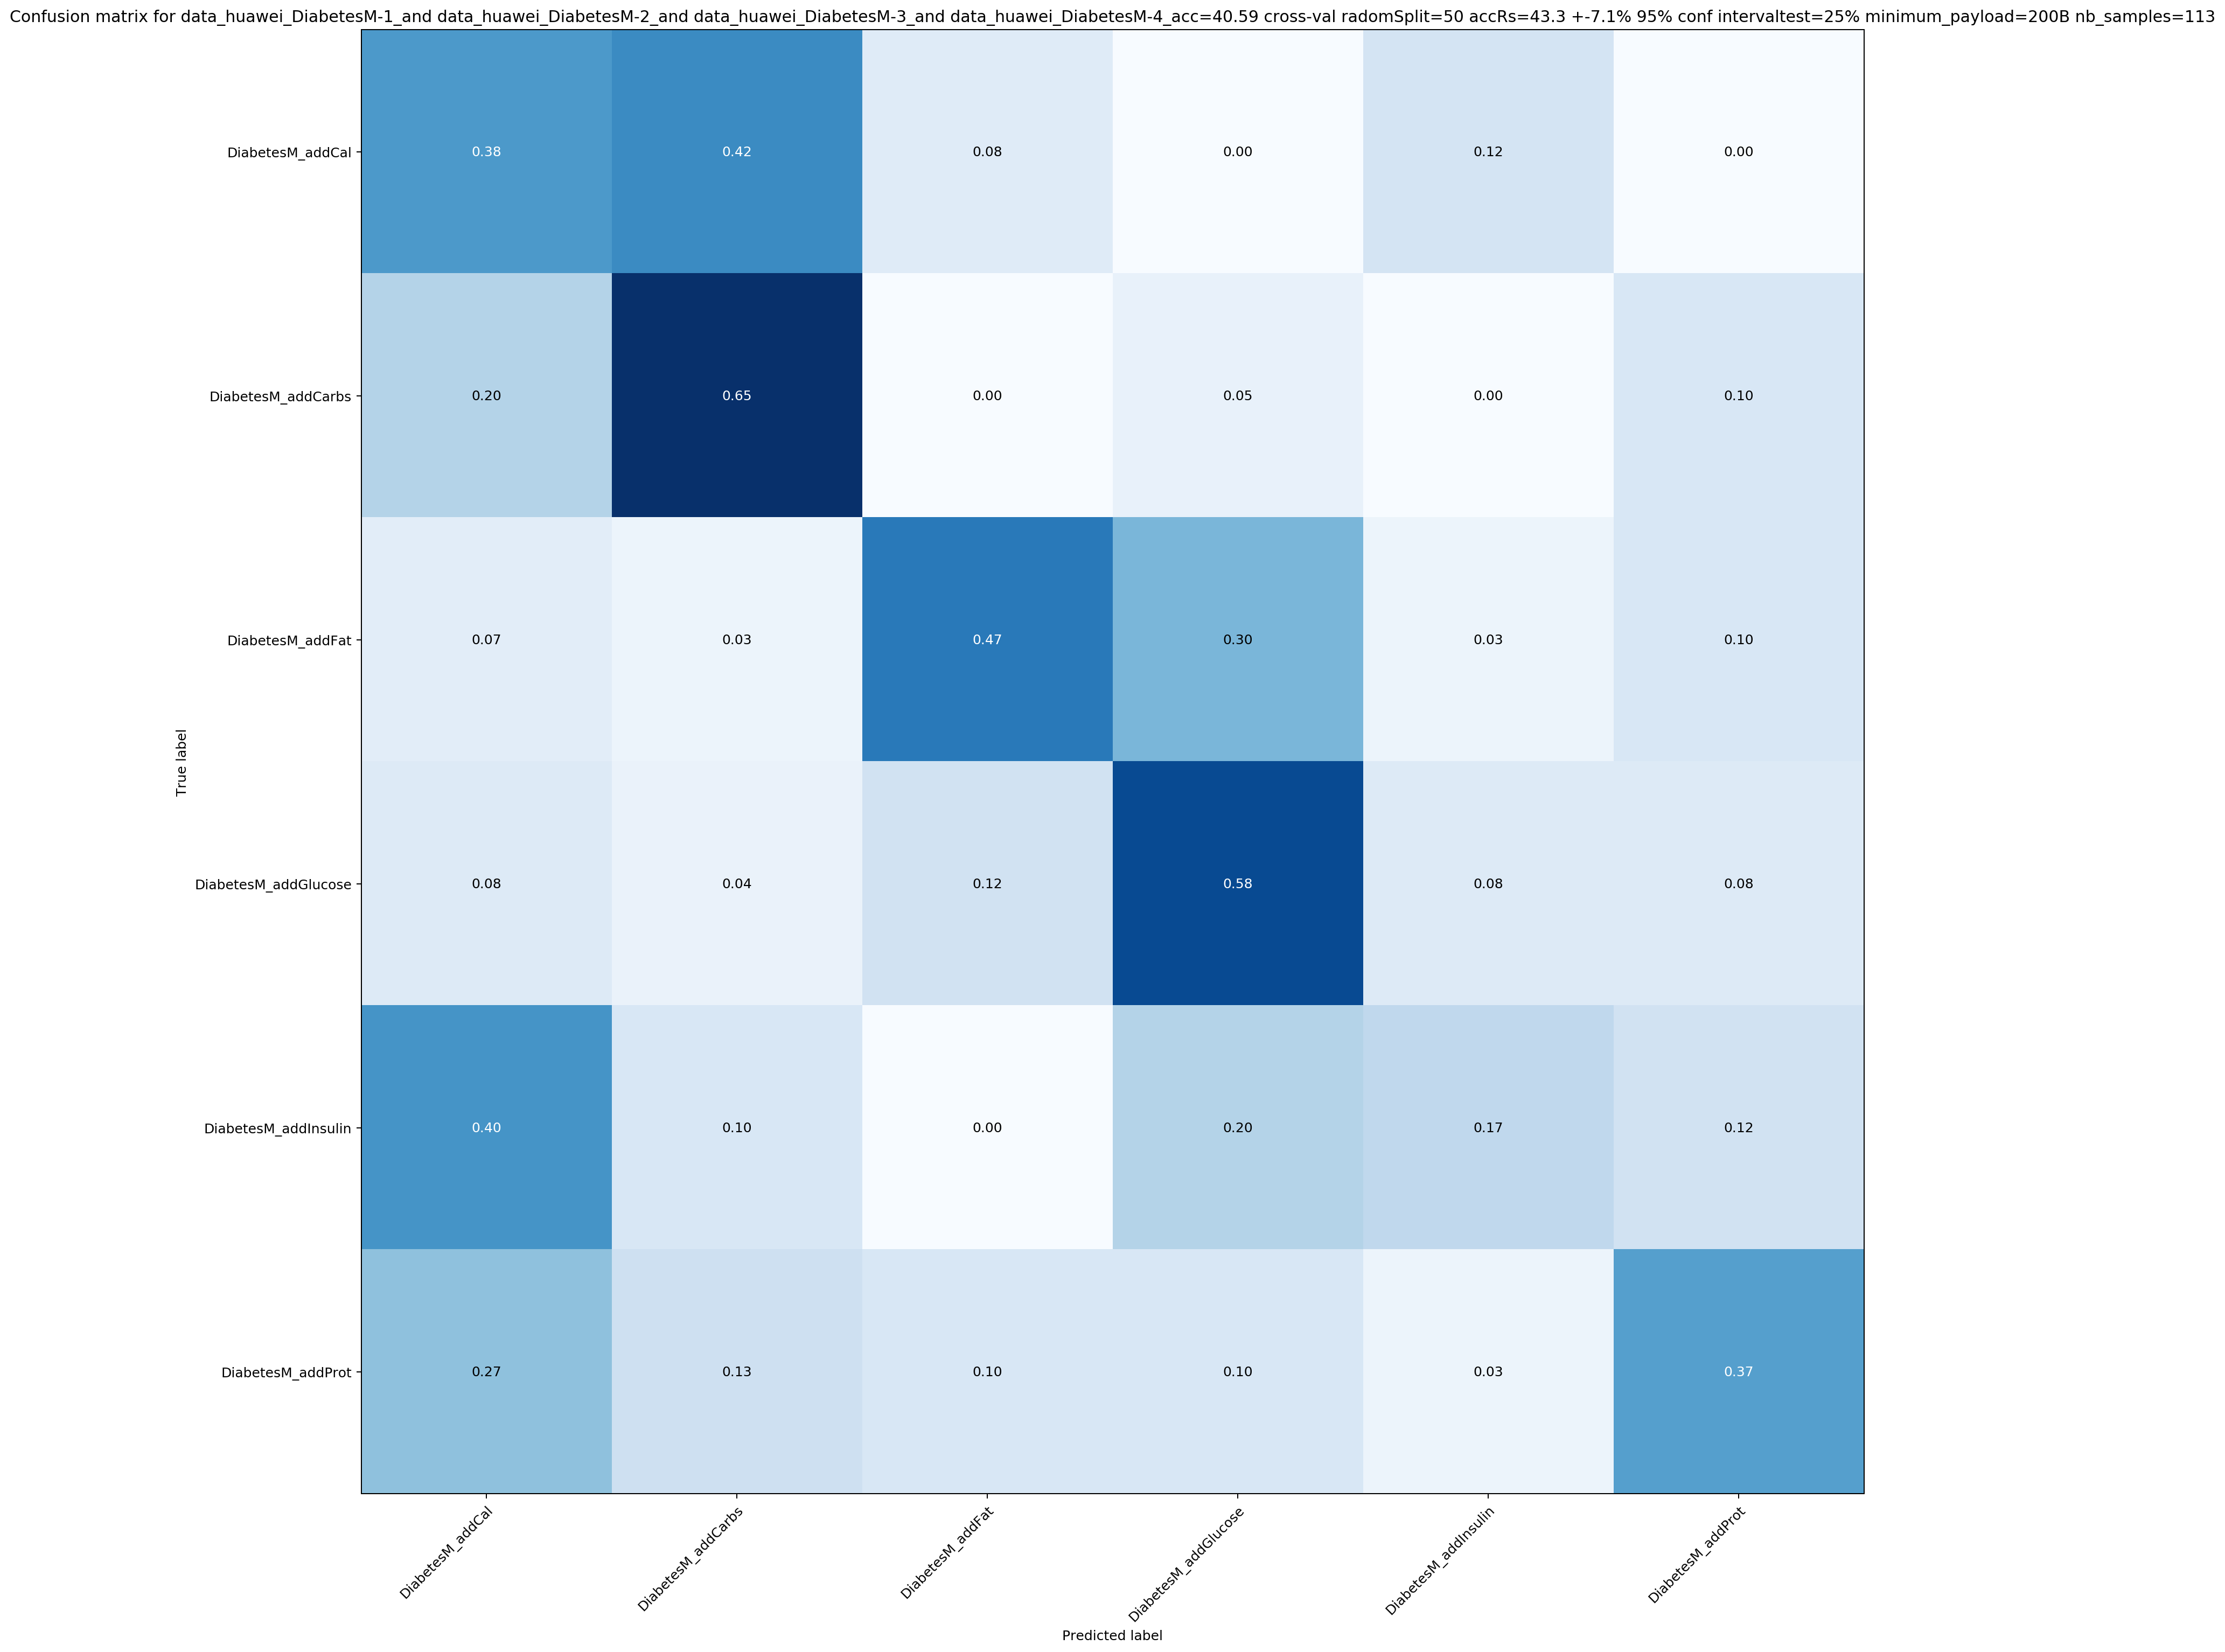

In [353]:
DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
DISCARDED_ACTION = ["DiabetesM_addCarbsaddInsulin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, SHUFFLE=True)

### Focus on addInsuline action


importing data...
merging events
to_merge_action_set =  {'addProt', 'addCarbs', 'addFat', 'addCal'}
filtering app that does not send traffic by their length

class event count
LEO-BX9: DiabetesM_addGlucose - 136
LEO-BX9: DiabetesM_addInsulin - 138
LEO-BX9: DiabetesM_addCaladdCarbsaddFataddProt - 563

dataset equalization per class

class event count after equalization
LEO-BX9: DiabetesM_addGlucose - 136
LEO-BX9: DiabetesM_addInsulin - 136
LEO-BX9: DiabetesM_addCaladdCarbsaddFataddProt - 136

building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.591 (+/- 0.08). 
building and training a model for confusion matrix
accuracy =  0.6568627450980392
Saved image ./plots/Confusion_matrix_for_data_huawei_DiabetesM-1_and_data_huawei_DiabetesM-2_and_data_huawei_DiabetesM-3_and_data_huawei_DiabetesM-4_acc=65_69_cross-val_radomSplit=50_accRs=59_1_+-7_6%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=136.png
done


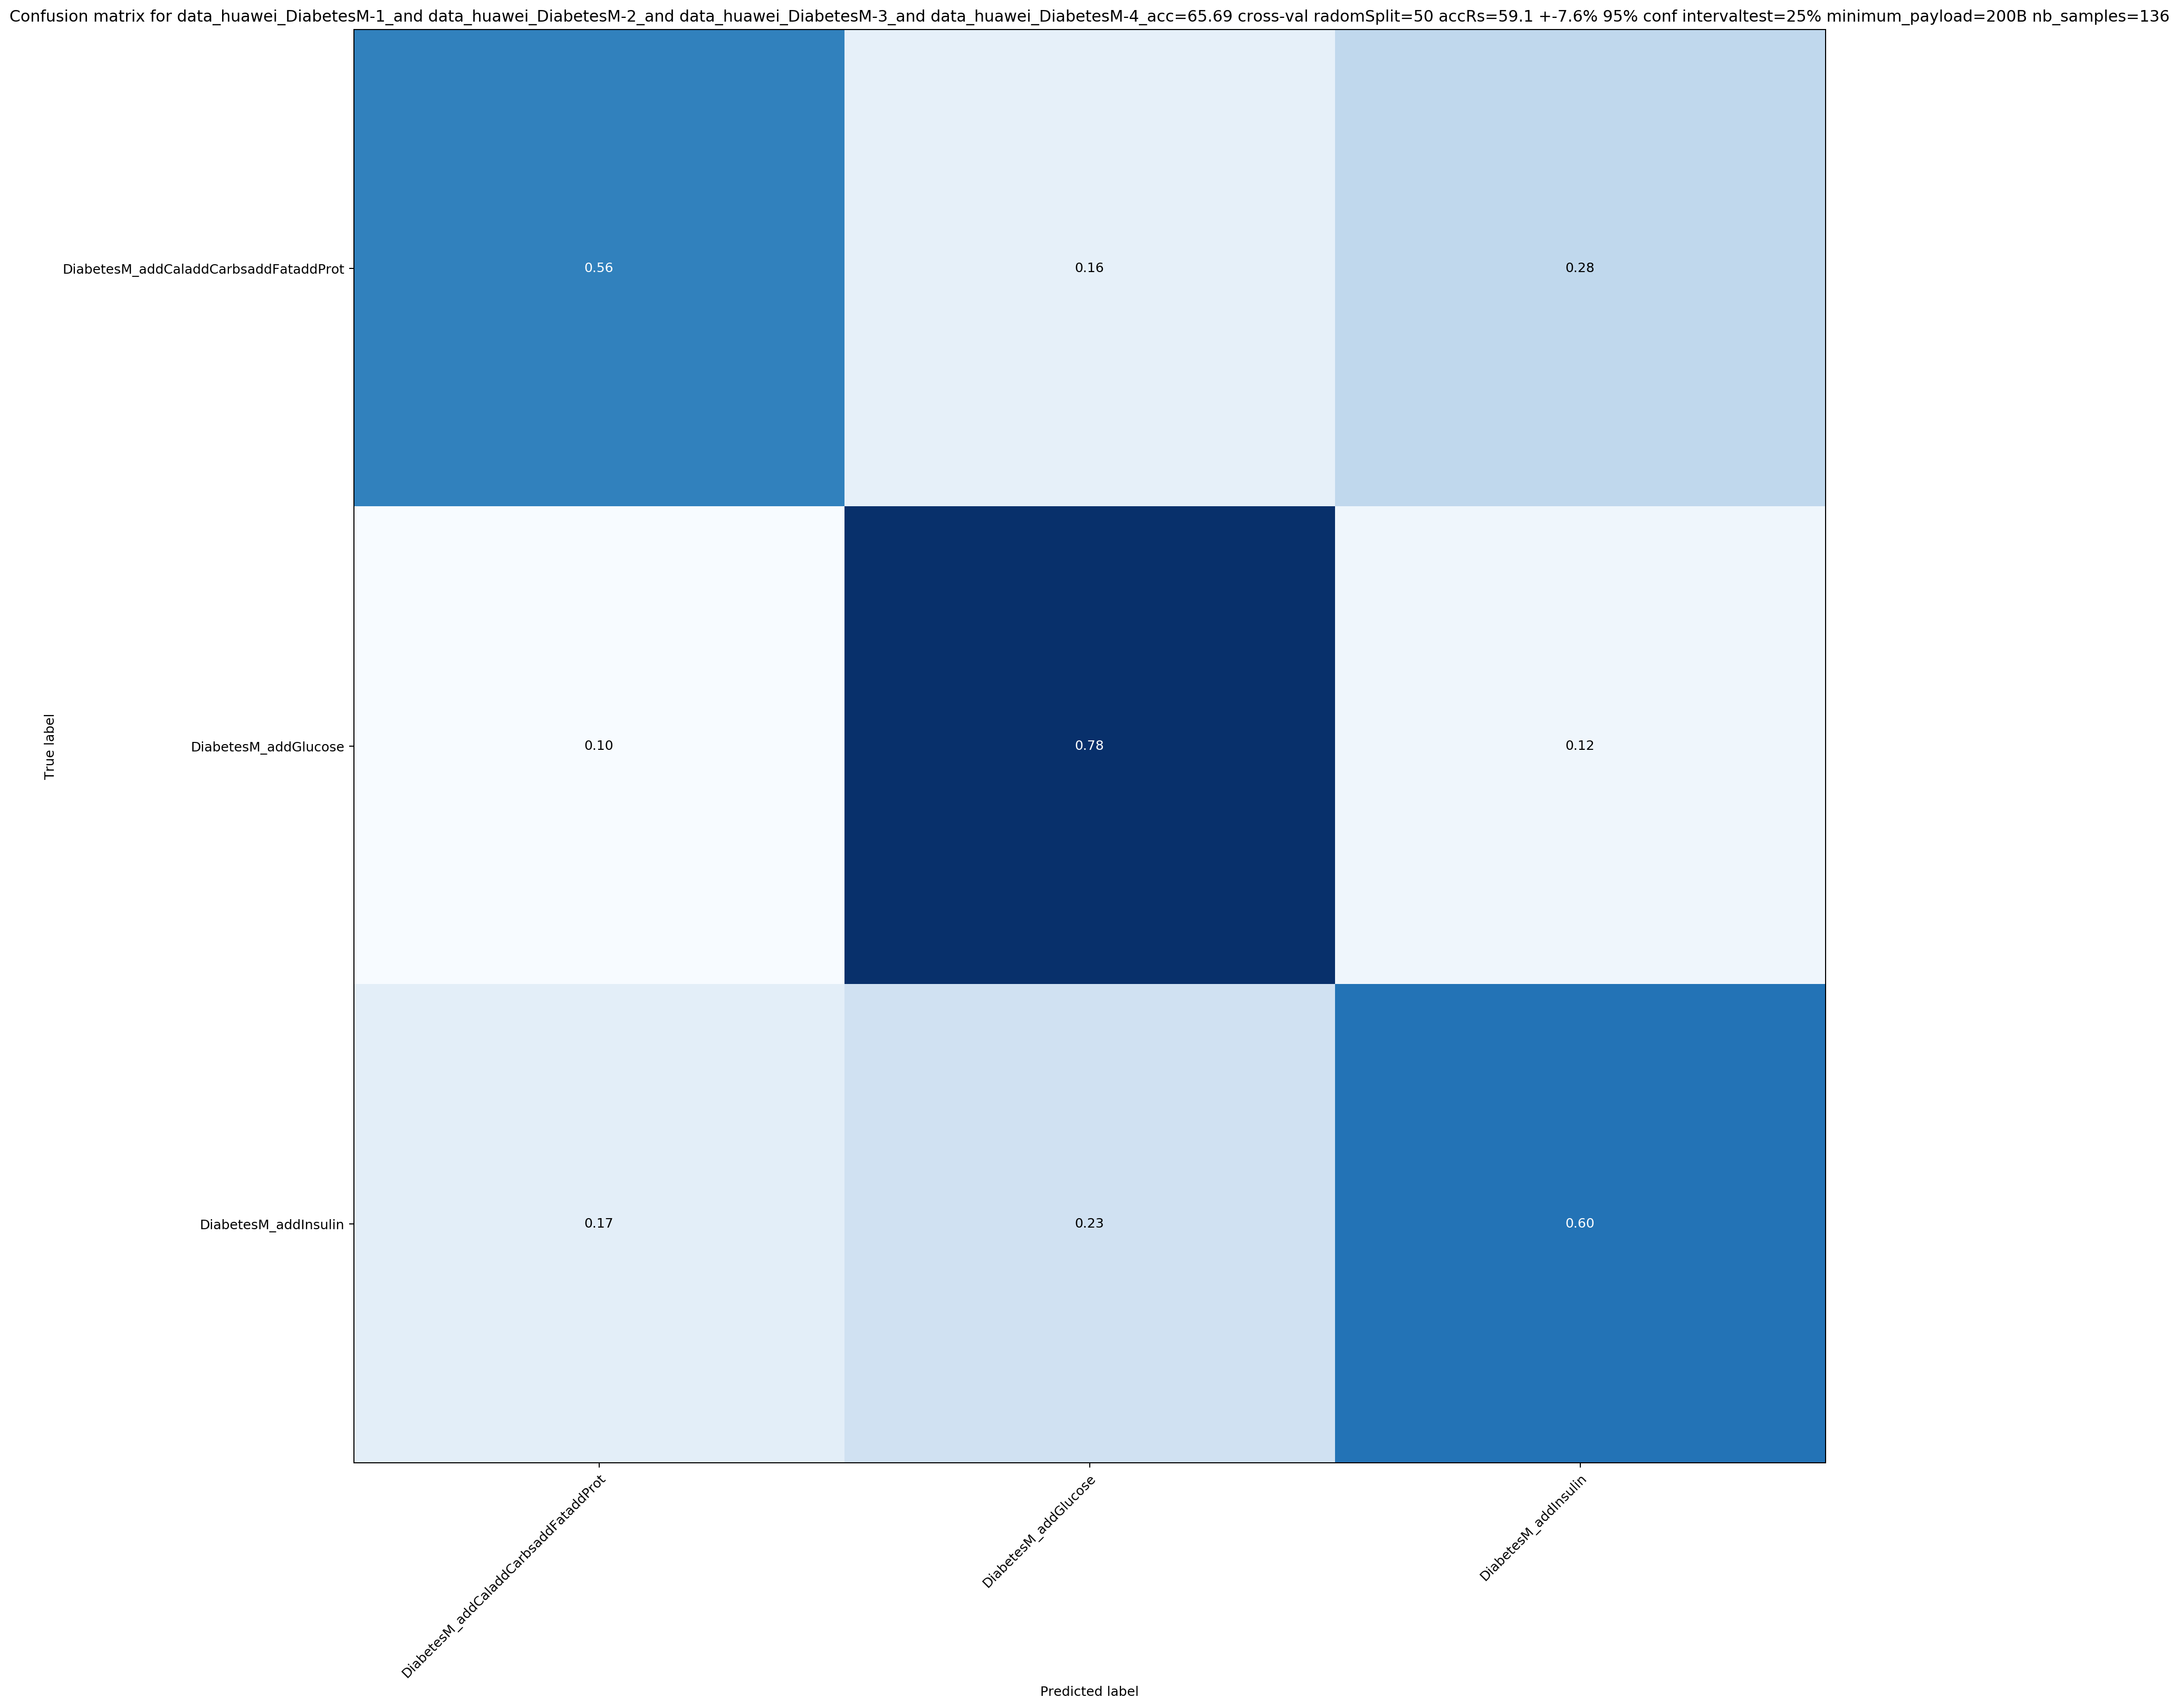

In [356]:
DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
TO_MERGE = [["DiabetesM_addCal", "DiabetesM_addCarbs", "DiabetesM_addFat", "DiabetesM_addProt"]] 
evaluate(DATA_PATH, TO_MERGE=TO_MERGE, PRINT_COUNT=True, N_ESTIMATOR=100)

In [380]:
precisions = []
recalls = []

[0.6857142857142857]

In [ ]:
# Merge further more

DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
TO_MERGE = [["DiabetesM_addCal", "DiabetesM_addCarbs", "DiabetesM_addFat", "DiabetesM_addProt", "DiabetesM_addGlucose"]] 

for _ in range(10):
    y_test, y_pred = evaluate(DATA_PATH, TO_MERGE=TO_MERGE, PRINT_COUNT=False, N_ESTIMATOR=100, RETURN_PRED= True)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=["DiabetesM_addInsulin"])
    precisions += precision.tolist()
    recalls += recall.tolist()

In [392]:
print("precisions_avg={} recall_avg={}".format(sum(precisions)/len(precisions),sum(recalls)/len(recalls)))
print("precision min: {} - max {}".format(min(precisions), max(precisions)))
print("recall_min: {} - max {}".format(min(precisions), max(precisions)))

precisions_avg=0.6821539602788173 recall_avg=0.6590413426914611
precision min: 0.5428571428571428 - max 0.8620689655172413
recall_min: 0.5428571428571428 - max 0.8620689655172413


Way to improve:
    - Make the dataset balanced when merging app (It could be that a class is much more present than other classes in the train and the in test it changes).
    - Use most prunning to isolate most important features and discard other features
    - Change the model to 1d convalution

<a id='transferability'></a>
## Transferability
[Table of content](#tc)
### For Huawei and Fossil both in train and test

Methodology: remove actions that are not common in both watches, balance data across watch and actions to be sure the 50% of the data are coming from huaweiwatch and the other 50% from Fossil per class. Mix all of it and separate train and test when the data is mixed. 

Disadventage: Does not ensure equilibrium wrt. watches in the test set (might be unbalanced but in average is balanced) (I can always change that)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
accuracy =  0.9380804953560371
Saved image ./plots/test.png


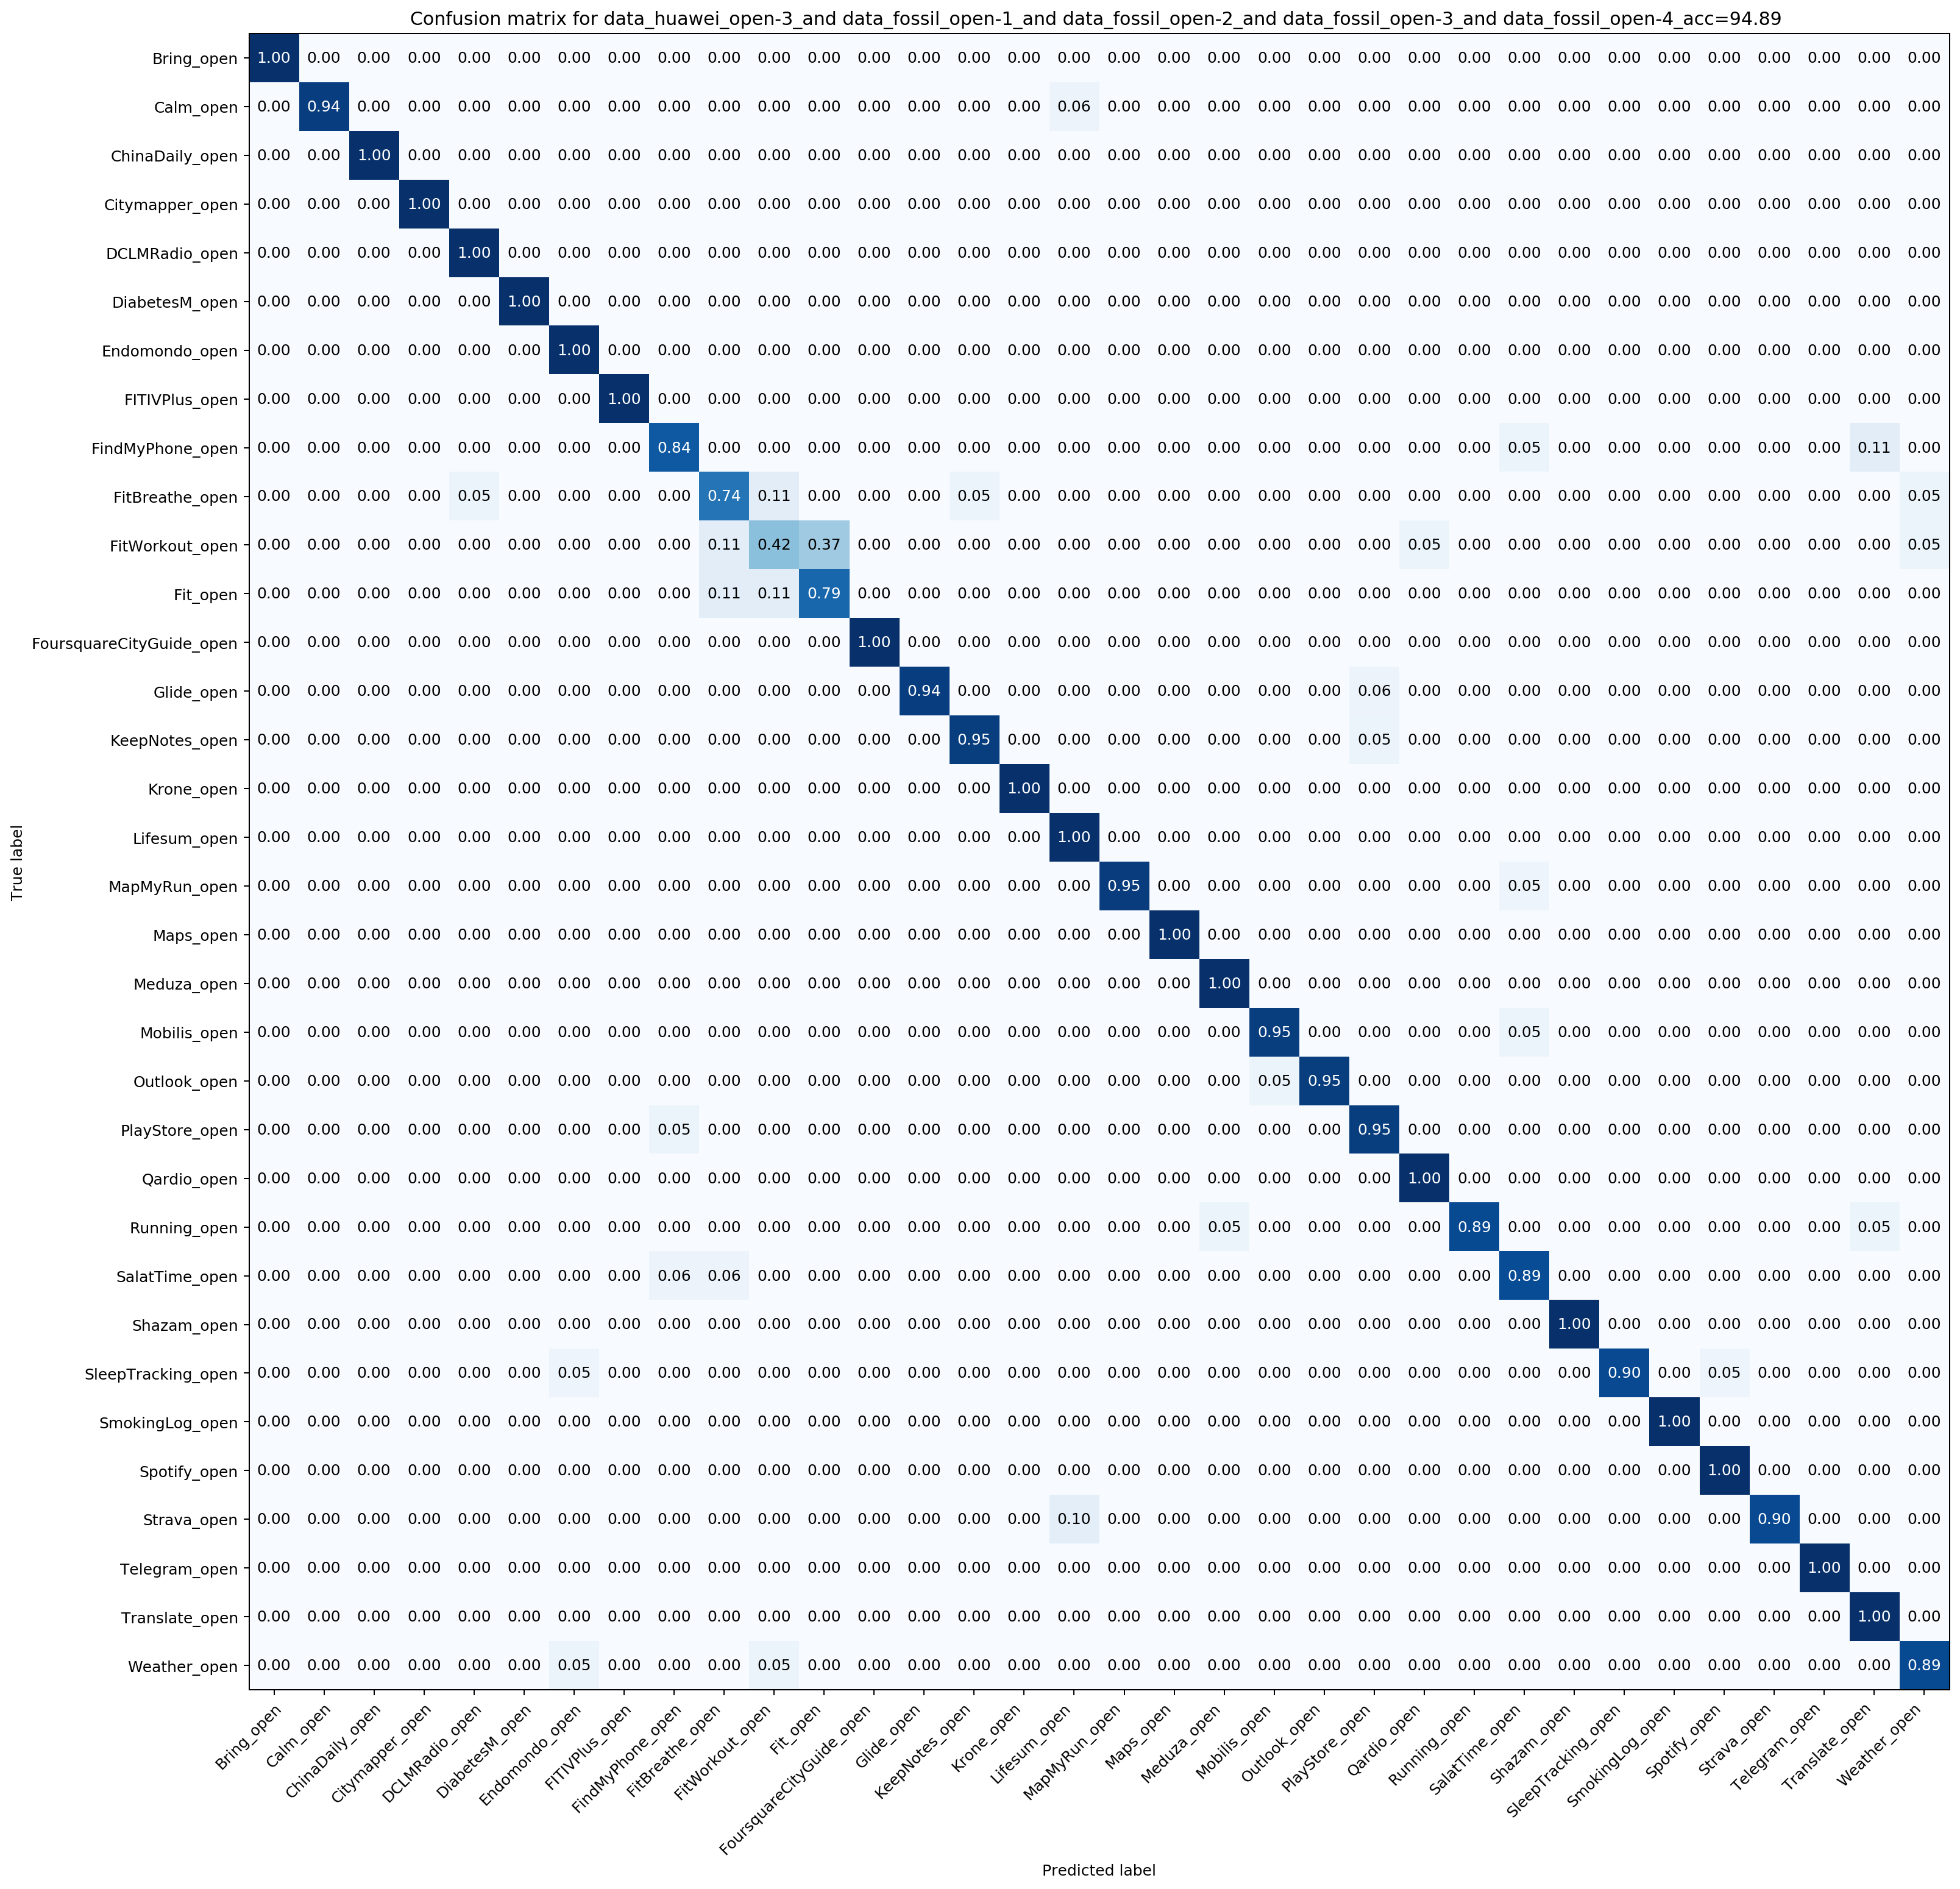

In [16]:
N_ESTIMATOR = 100
REPEAT = 50
DATA_PATH = ["data/huawei/open-3/", "data/fossil/open-1/", "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
equilibrate_events = evaluate(DATA_PATH, RETURN_EQUILIBRATE_EVENTS=True)

equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features and labels")
X_huawei, y_huawei = build_features_labels_dataset(equilibrate_events_huawei)
X_fossil, y_fossil = build_features_labels_dataset(equilibrate_events_fossil)



X_train_huawei, X_test_huawei, y_train_huawei, y_test_huawei = train_test_split(X_huawei, y_huawei, stratify=y_huawei, test_size=0.25, random_state=None)
X_train_fossil, X_test_fossil, y_train_fossil, y_test_fossil = train_test_split(X_fossil, y_fossil, stratify=y_fossil, test_size=0.25, random_state=None)

X_train = X_train_huawei + X_train_fossil
y_train = y_train_huawei + y_train_fossil

X_test = X_test_huawei + X_test_fossil
y_test = y_test_huawei + y_test_fossil


clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("accuracy = ", accuracy)


cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, save = "test", PLOT_DIR="./plots/")
# accuracies = []
# for _ in re




importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.939 (+/- 0.02). 
building and training a model for confusion matrix
accuracy =  0.9458204334365325
Saved image ./plots/Confusion_matrix_for_data_huawei_open-3_and_data_fossil_open-1_and_data_fossil_open-2_and_data_fossil_open-3_and_data_fossil_open-4_acc=94_58_cross-val_radomSplit=50_accRs=93_9_+-1_6%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=38.png
done


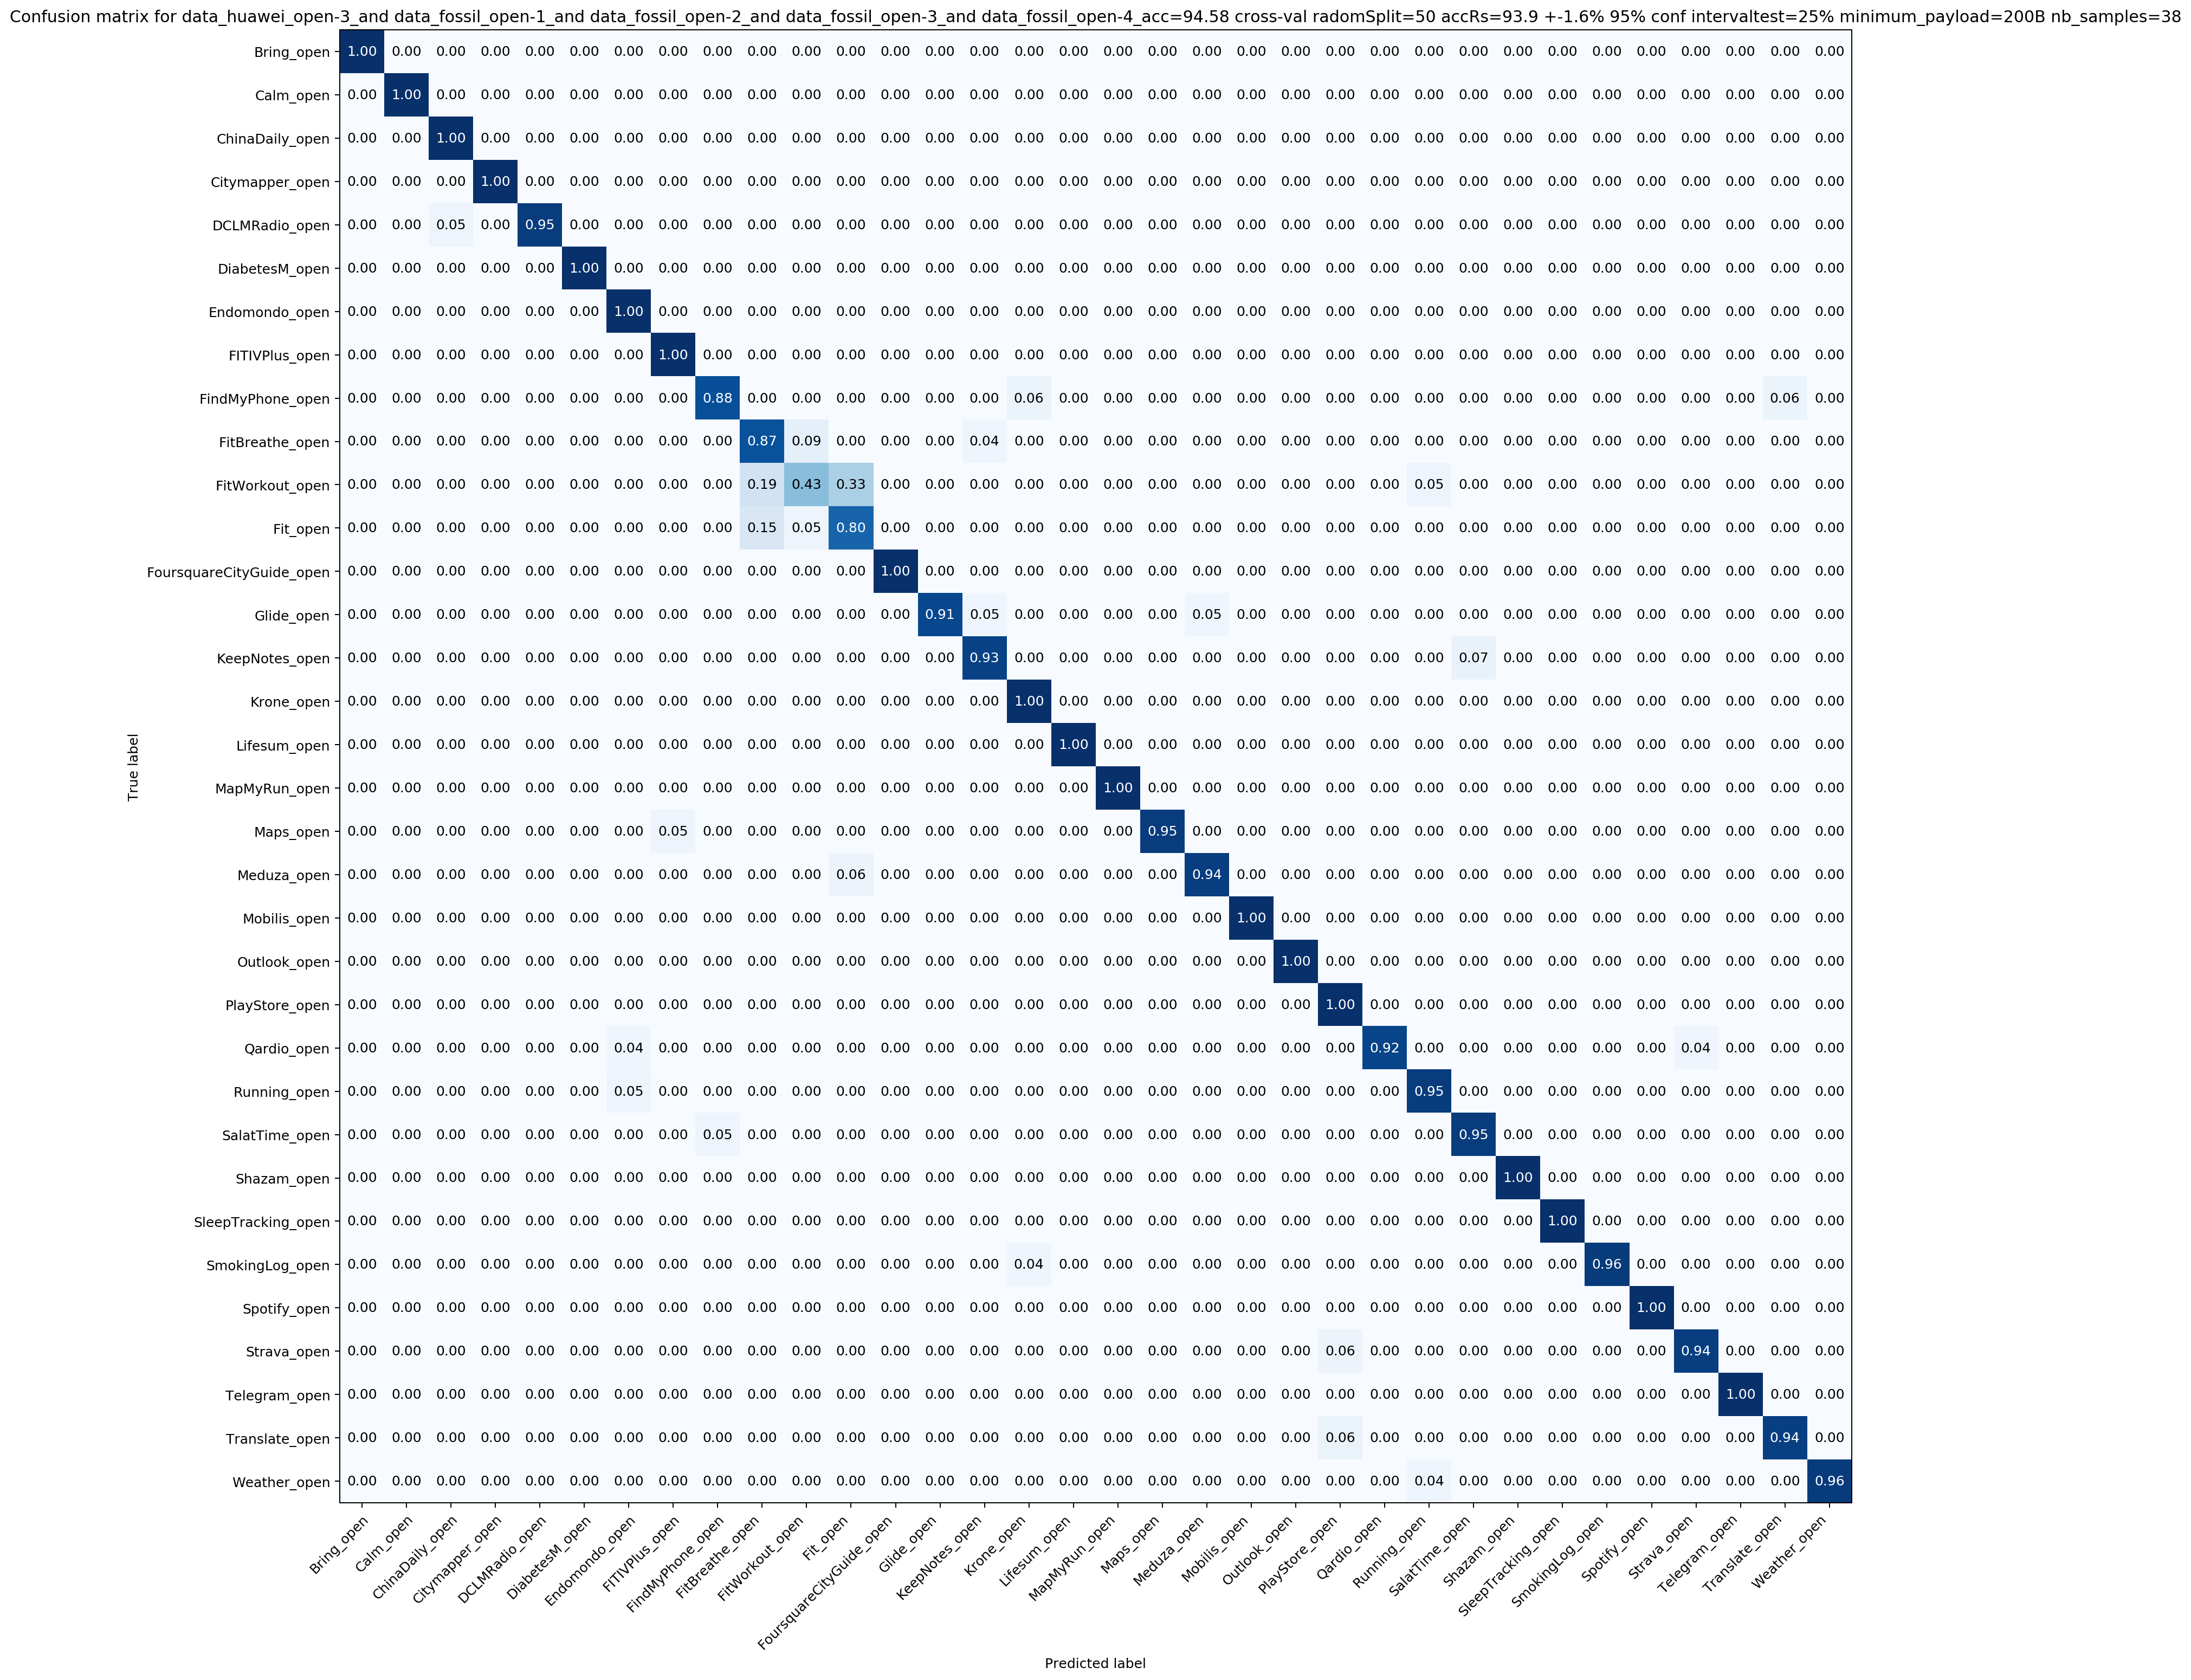

In [94]:
DATA_PATH = ["data/huawei/open-3/", "data/fossil/open-1/", "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
evaluate(DATA_PATH, print_count=False)

#### Same has above but with separation on the watch class: expect much less accuracy (2x more data which are 2 by 2 similar )


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length
dataset equalization per class
separate watch action
building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.937 (+/- 0.02). 
building and training a model for confusion matrix
accuracy =  0.9489164086687306
Saved image ./plots/Confusion_matrix_for_data_huawei_open-3_and_data_fossil_open-1_and_data_fossil_open-2_and_data_fossil_open-3_and_data_fossil_open-4_acc=94_89_cross-val_radomSplit=50_accRs=93_7_+-1_8%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=38.png
done


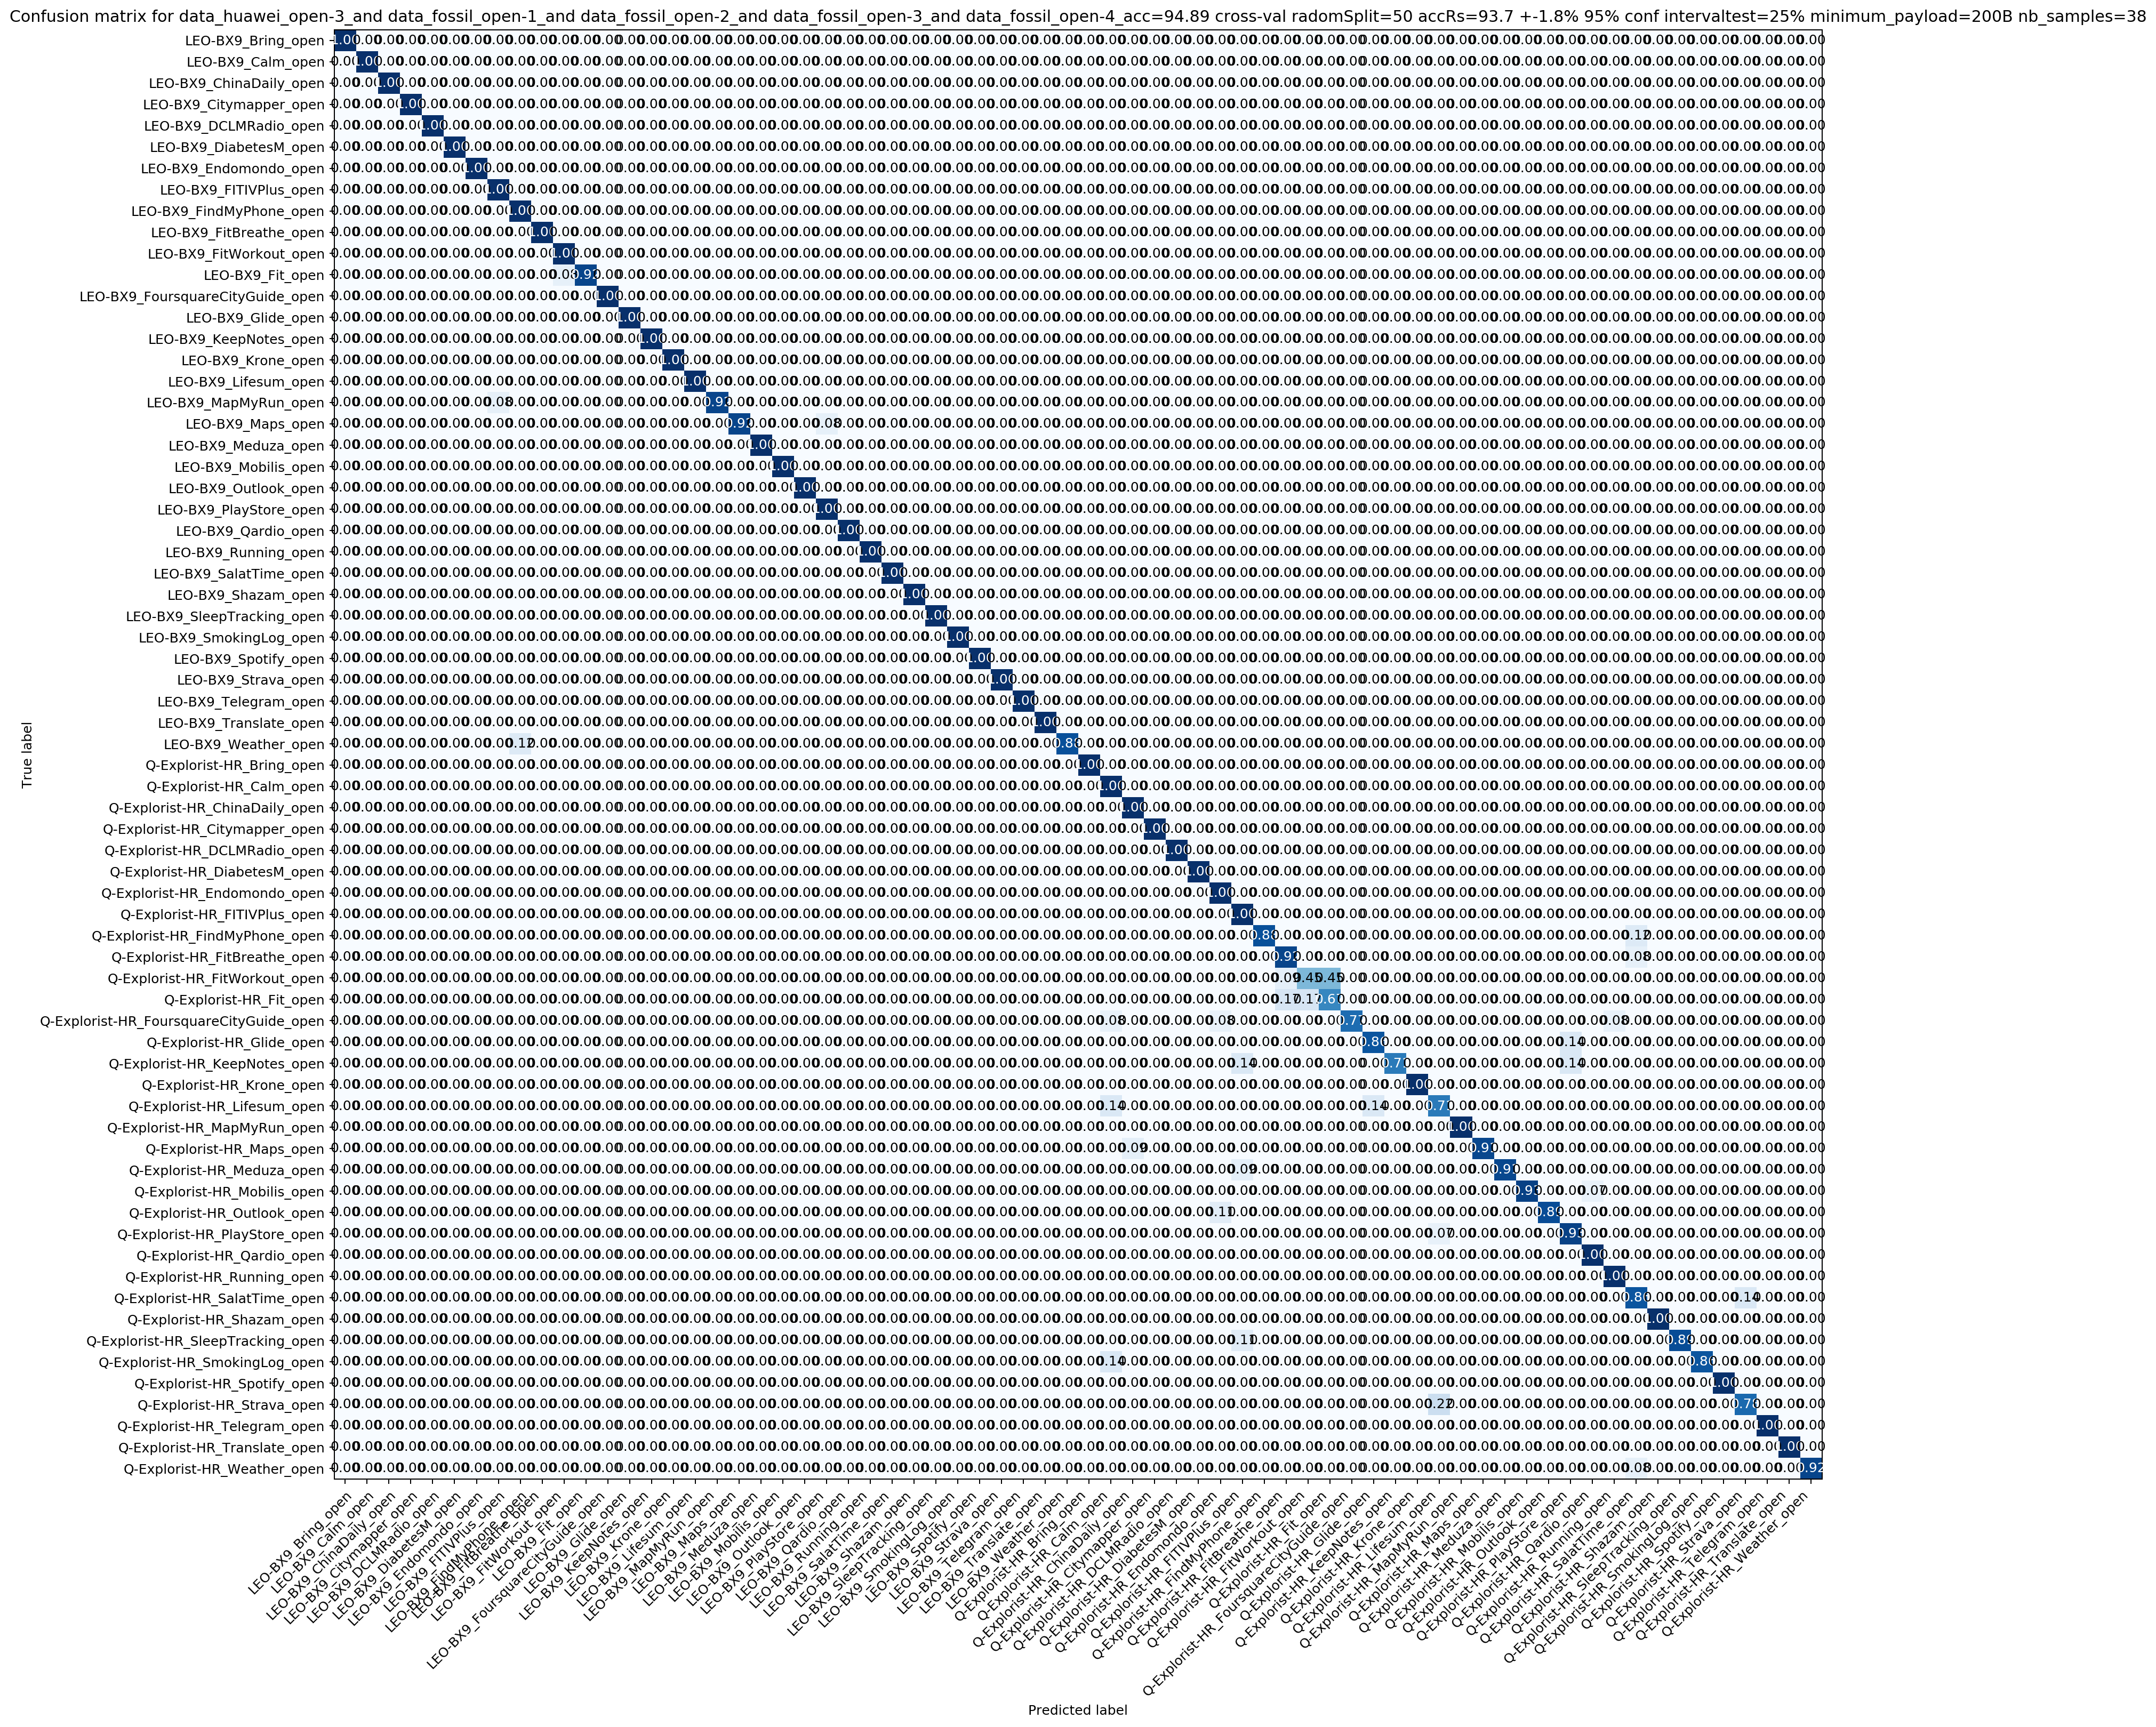

In [158]:
DATA_PATH = ["data/huawei/open-3/", "data/fossil/open-1/", "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARDED_ACTION = ["WashPost_openConnectionError", "AppInTheAir_openNotLogin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, SEPARATE_WATCH=True)

### Training and testing with different watch respectively
[table of content](#tc)

Methodology: Delete app that does not occur in either the huawei and fossil dataset. Use all the huawei dataset to train, use all the Fossil dataset to test and vice versa

#### Setup

In [5]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/", "data/huawei/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
equilibrate_events = evaluate(DATA_PATH,  PRINT_COUNT=True, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events_events["LEO-BX9"]
equilibrate_events_events_fossil["Q-Explorist-HR"] = equilibrate_events_events["Q-Explorist-HR"]

print("building features and labels")
X_huawei, y_huawei = build_features_labels_dataset(filtered_events_huawei)
X_fossil, y_fossil = build_features_labels_dataset(filtered_events_fossil)


importing data...
filtering app that does not send traffic by their length

class event count
Q-Explorist-HR: Bring_open - 30
Q-Explorist-HR: Calm_open - 28
Q-Explorist-HR: ChinaDaily_open - 28
Q-Explorist-HR: Citymapper_open - 28
Q-Explorist-HR: DCLMRadio_open - 28
Q-Explorist-HR: DiabetesM_open - 28
Q-Explorist-HR: Endomondo_open - 28
Q-Explorist-HR: FITIVPlus_open - 28
Q-Explorist-HR: FindMyPhone_open - 29
Q-Explorist-HR: FitBreathe_open - 28
Q-Explorist-HR: FitWorkout_open - 27
Q-Explorist-HR: Fit_open - 27
Q-Explorist-HR: FoursquareCityGuide_open - 28
Q-Explorist-HR: Glide_open - 28
Q-Explorist-HR: KeepNotes_open - 28
Q-Explorist-HR: Krone_open - 29
Q-Explorist-HR: Lifesum_open - 28
Q-Explorist-HR: MapMyRun_open - 28
Q-Explorist-HR: Maps_open - 29
Q-Explorist-HR: Meduza_open - 29
Q-Explorist-HR: Mobilis_open - 24
Q-Explorist-HR: Outlook_open - 28
Q-Explorist-HR: PlayStore_open - 28
Q-Explorist-HR: Qardio_open - 26
Q-Explorist-HR: Running_open - 28
Q-Explorist-HR: SalatTime_open -

NameError: name 'filtered_events' is not defined

#### Train with Huawei, test with Fossil

building and training the model for cross validation 
building and training a model for confusion matrix
accuracy =  0.6397134083930399
Saved image ./plots/Confusion_matrix_train_with_Huawei_test_with_Fossil_acc=63_97_.png


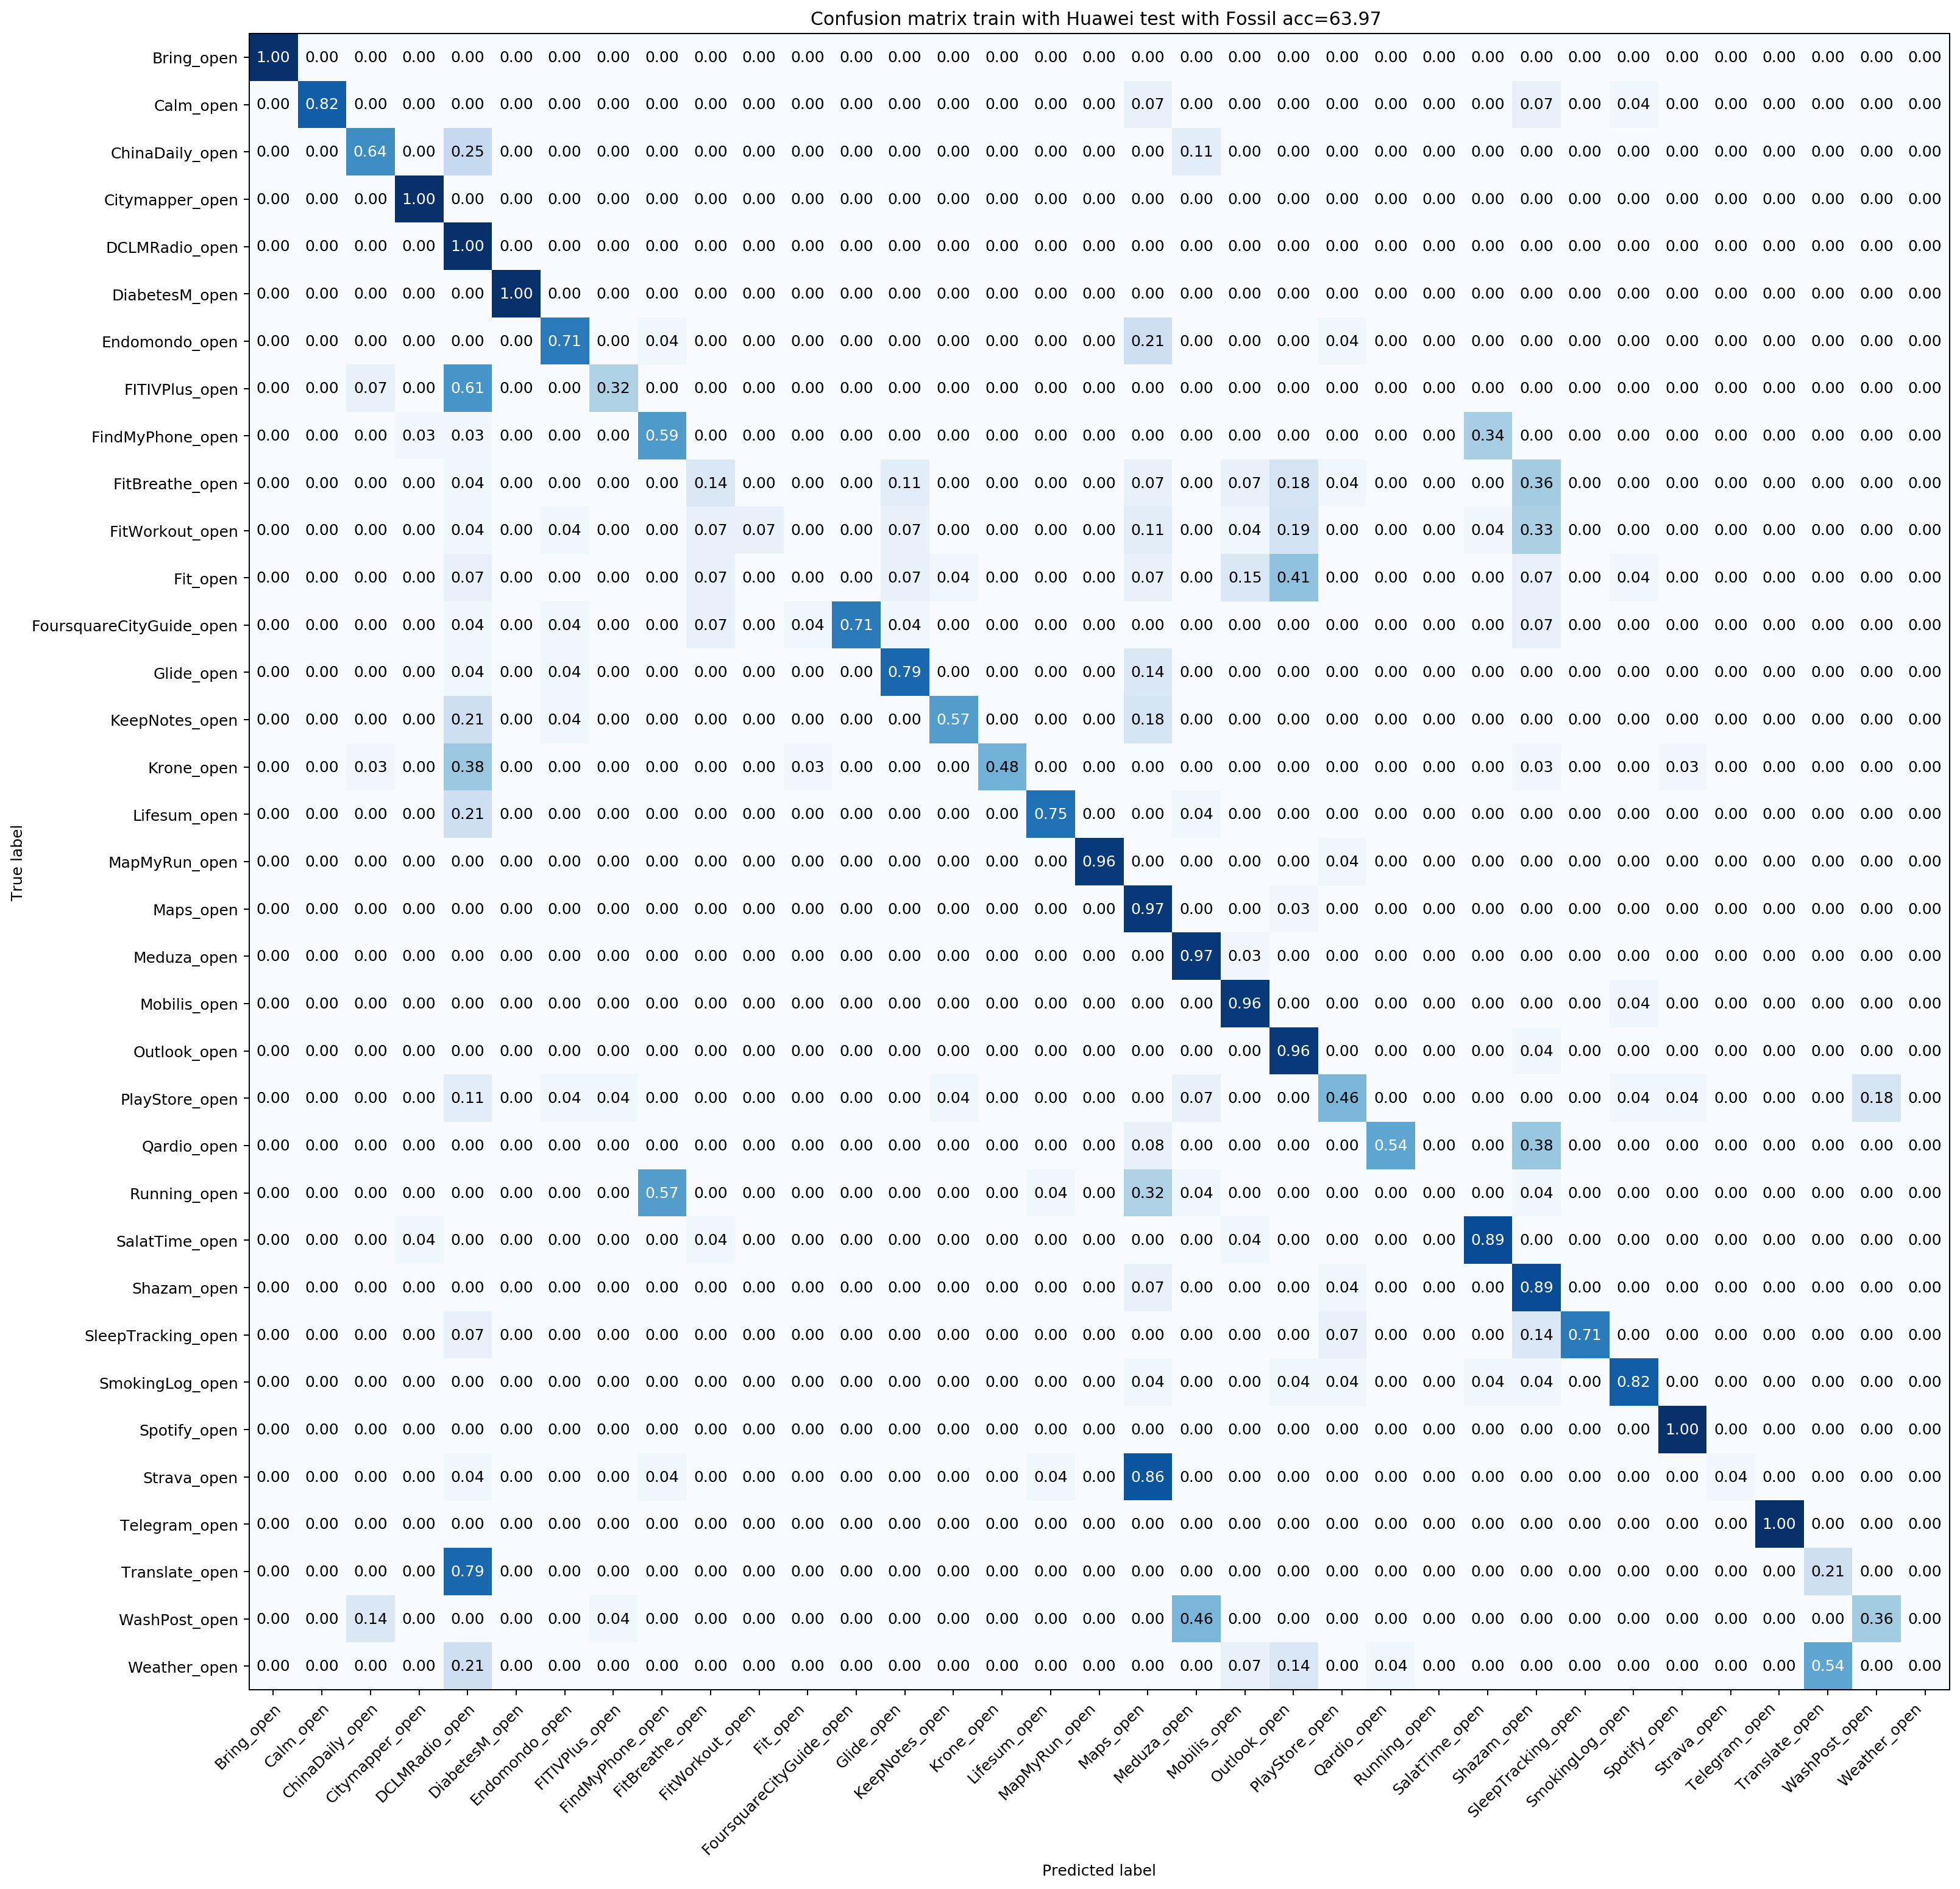

In [32]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")

clf.fit(X_huawei, y_huawei)
y_fossil_pred = clf.predict(X_fossil)

accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
print("accuracy = ", accuracy)


title = "Confusion matrix train with Huawei test with Fossil acc={:0.2f} ".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_fossil, y_fossil_pred, title= title, save = saved_title)


#### Train with Fossil, test with Huawei

building and training the model for cross validation 
building and training a model for confusion matrix
accuracy =  0.6682892906815021
Saved image ./plots/Confusion_matrix_train_with_Fossil_test_with_Huawei_acc=66_83_.png


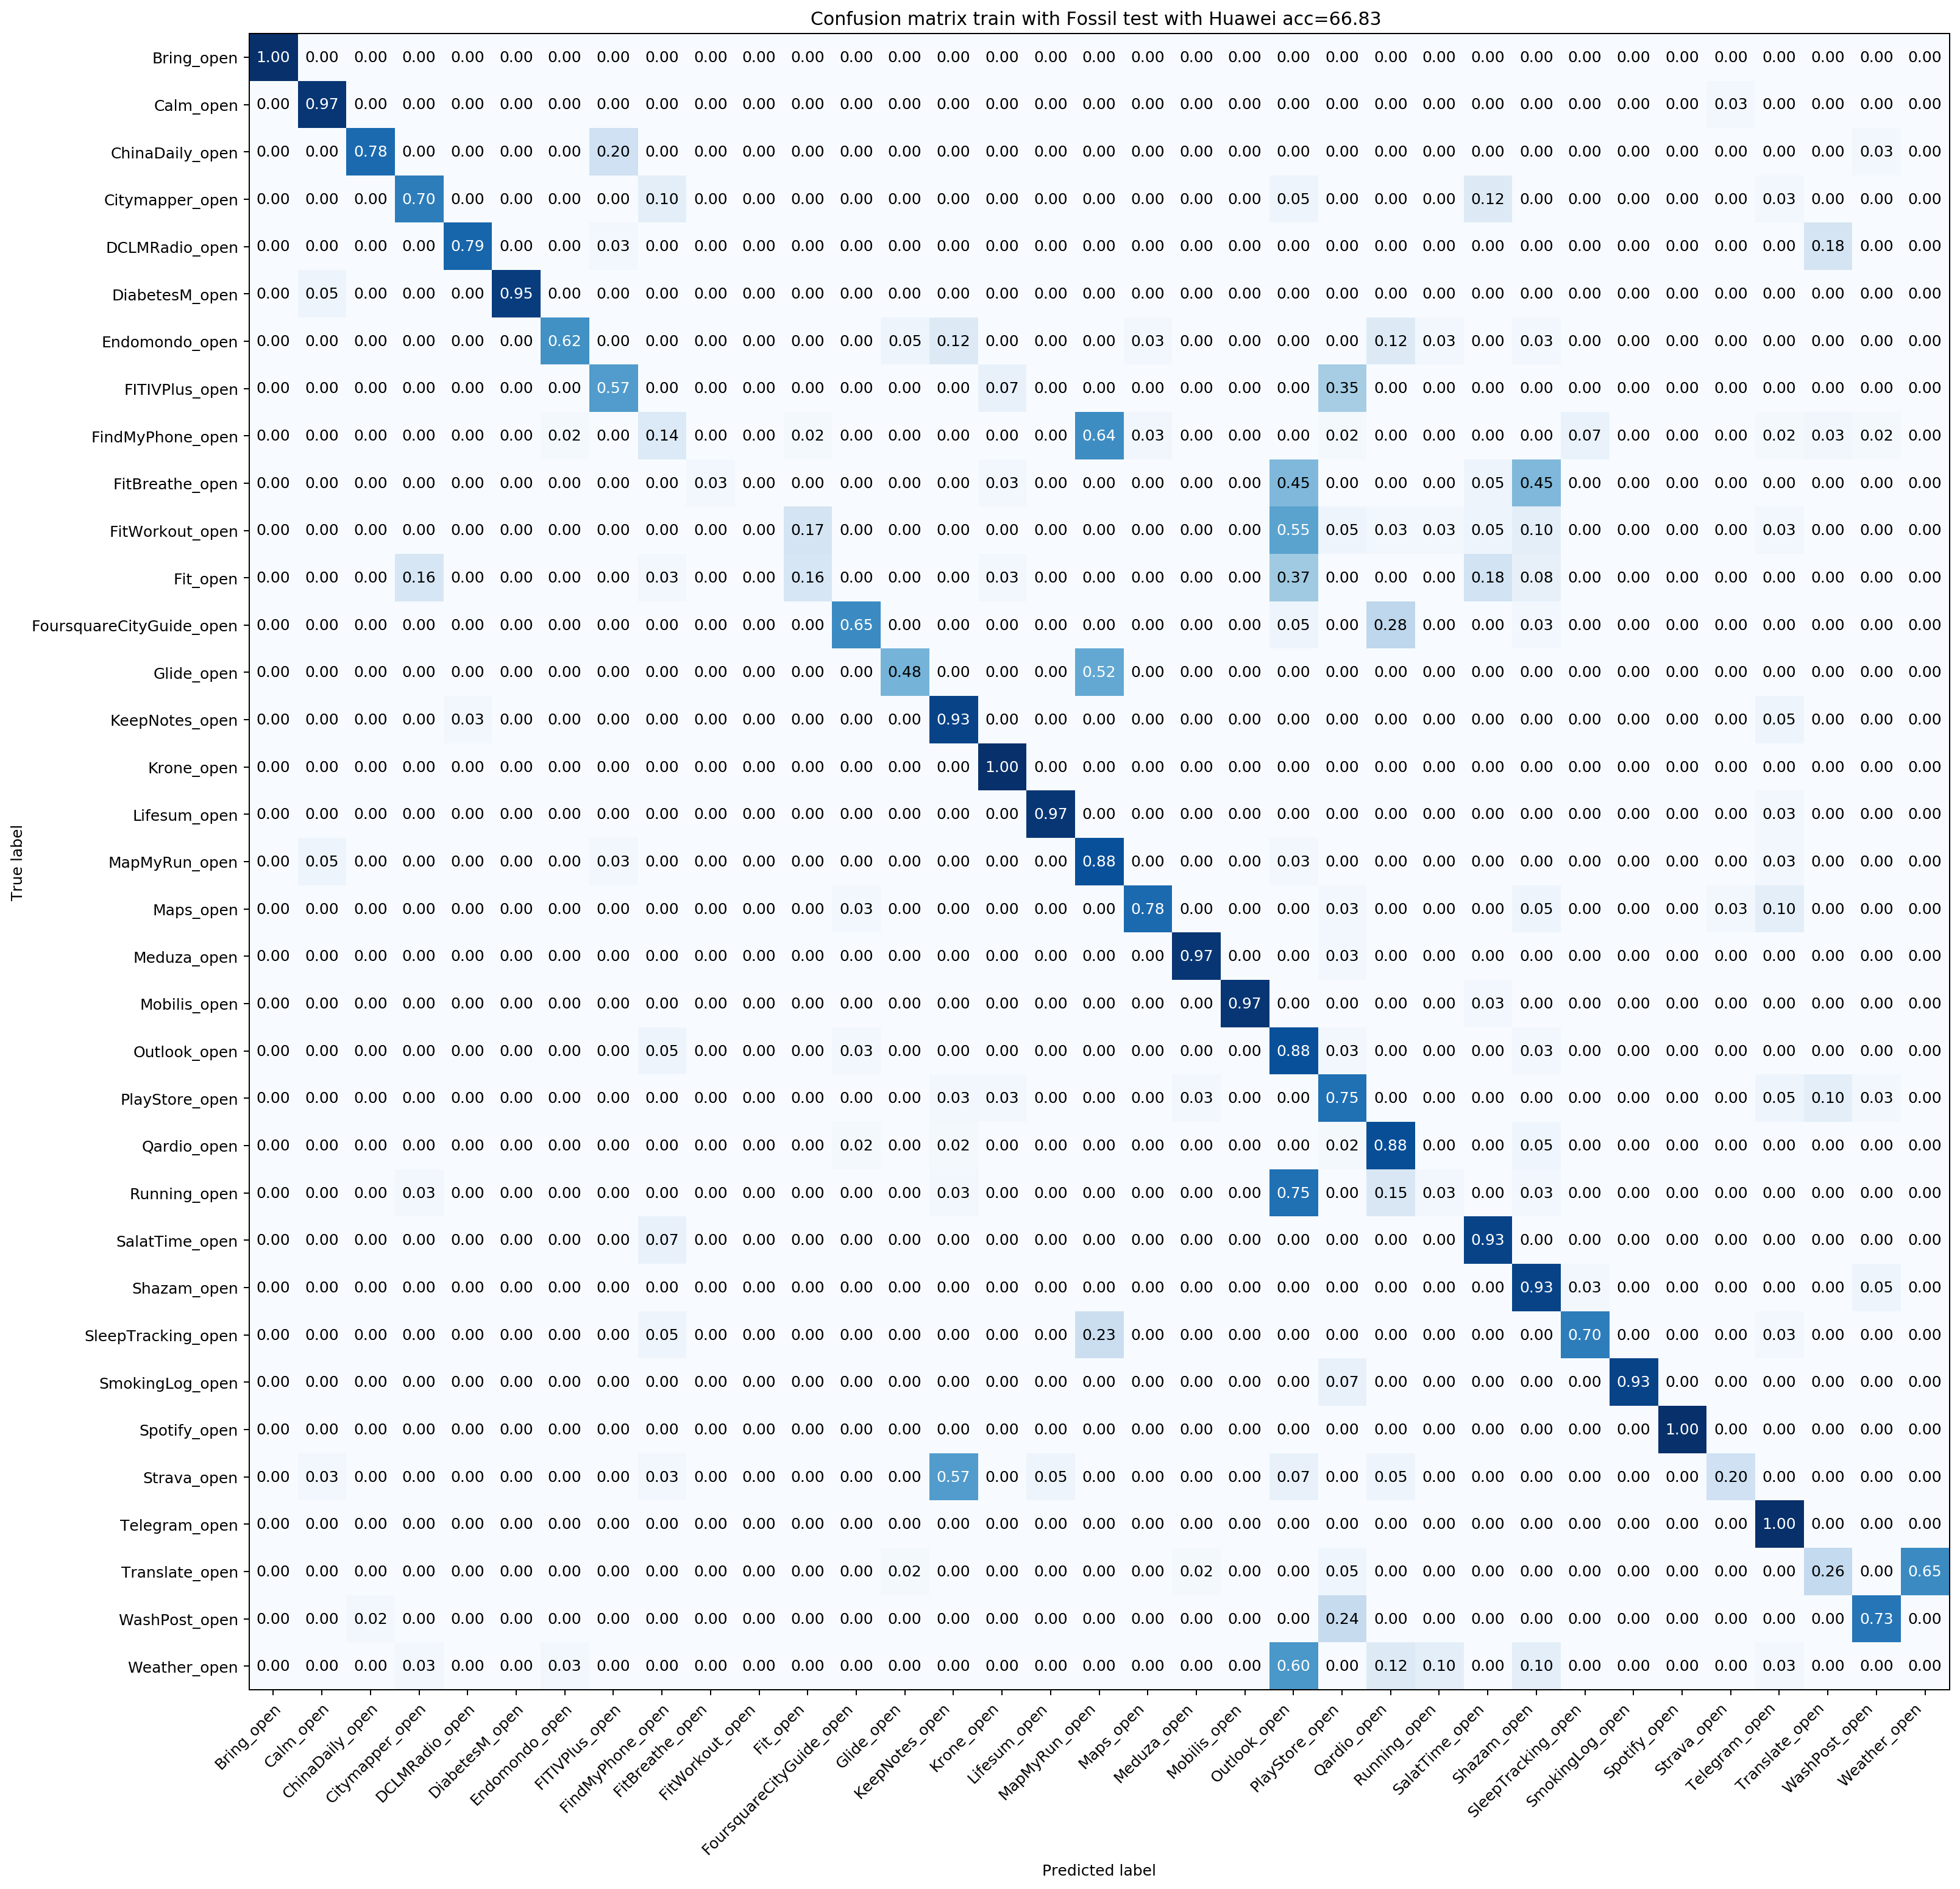

In [34]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")
X_fossil, y_fossil = shuffle(X_fossil, y_fossil)
clf.fit(X_fossil, y_fossil)
y_huawei_pred = clf.predict(X_huawei)
accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
print("accuracy = ", accuracy)



title = "Confusion matrix train with Fossil test with Huawei acc={:0.2f} ".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_huawei, y_huawei_pred, title= title, save = saved_title, PLOT_DIR="./plots/")

### Exploring probabilities of missclassifed elements

In [44]:
y_pred = clf.predict(X_fossil[5:6])
clf.predict_proba()

array([[0.003, 0.015, 0.026, 0.022, 0.118, 0.013, 0.016, 0.053, 0.211,
        0.019, 0.01 , 0.113, 0.008, 0.024, 0.024, 0.016, 0.003, 0.005,
        0.02 , 0.012, 0.041, 0.011, 0.015, 0.011, 0.03 , 0.015, 0.012,
        0.008, 0.126]])

In [38]:
y_fossil[5:6]

['Fit_open']

In [39]:
clf.predict_proba(X_fossil[10:11])

array([[0.004, 0.001, 0.047, 0.018, 0.044, 0.039, 0.004, 0.006, 0.008,
        0.015, 0.04 , 0.399, 0.017, 0.093, 0.008, 0.007, 0.013, 0.003,
        0.01 , 0.075, 0.017, 0.031, 0.003, 0.005, 0.005, 0.016, 0.019,
        0.044, 0.009]])

In [40]:
y_fossil[10:11]

['KeepNotes_open']

TODO: Clean fossil dataset

TODO: Class the matrix by length median see if the classes with a lot of FN are isolated

### Capacity vs Transferability

#### Increase model complexity 

In [ ]:
repeat = 50
n_samples_fossil = n_samples_fossil = []
accuracies_fossil = n_samples_fossil = []
for i in range(40, 710, 10):
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        X_train, X_test, y_train, y_test = train_test_split(X_fossil, y_fossil, test_size=0.25, random_state=None)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        n_samples_fossil.append(i)
        accuracies_fossil.append(accuracy)



In [ ]:
title = "Fossil train and test\nAccuacy against model complexity averaged over {} run".format(repeat)
fname = "./Results/Accuacy_against_model_complexity Fossil.png"
plot_acc_and_conf(n_samples_fossil, accuracies_fossil, title, fname)

![t](./Results/Accuacy_against_model_complexity_Fossil.png)

In [ ]:
# This might take some time to run. (1h30min)
n_samples_trans = []
accuracies_trans = []
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_huawei_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
        n_samples_trans.append(i)
        accuracies_trans.append(accuracy)

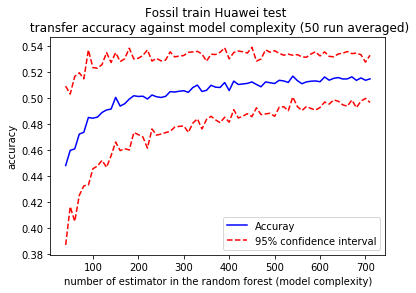

In [395]:
plot_acc_and_conf(n_samples_trans, accuracies_trans, title="Fossil train Huawei test \n transfer accuracy against model complexity ({} run averaged)".format(repeat), fname="./Results/transfer_accuracy_to_complexity.png")

### Decrease number of features
Using Shap value

Using shap value with the dataset containing both watches


### Accuracy vs Temporal and Environmental changes

In this subsection, we show what happens to the accuracy if we redo a capture

To that end, after 


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length
dataset equalization per class

After deleting
Q-Explorist-HR: Bring_open - 48
Q-Explorist-HR: Citymapper_open - 57
Q-Explorist-HR: DCLMRadio_open - 70
Q-Explorist-HR: DiabetesM_open - 48
Q-Explorist-HR: Endomondo_open - 46
Q-Explorist-HR: FITIVPlus_open - 46
Q-Explorist-HR: FindMyPhone_open - 46
Q-Explorist-HR: FitBreathe_open - 46
Q-Explorist-HR: FitWorkout_open - 51
Q-Explorist-HR: FoursquareCityGuide_open - 64
Q-Explorist-HR: Glide_open - 43
Q-Explorist-HR: KeepNotes_open - 56
Q-Explorist-HR: Krone_open - 63
Q-Explorist-HR: Lifesum_open - 54
Q-Explorist-HR: MapMyRun_open - 42
Q-Explorist-HR: Maps_open - 71
Q-Explorist-HR: Meduza_open - 67
Q-Explorist-HR: Mobilis_open - 67
Q-Explorist-HR: Outlook_open - 68
Q-Explorist-HR: PlayStore_open - 71
Q-Explorist-HR: Running_open - 47
Q-Explorist-HR: SalatTime_open - 46
Q-Explorist-HR: Shazam_open - 63
Q-Explorist-HR: SleepTracking_open

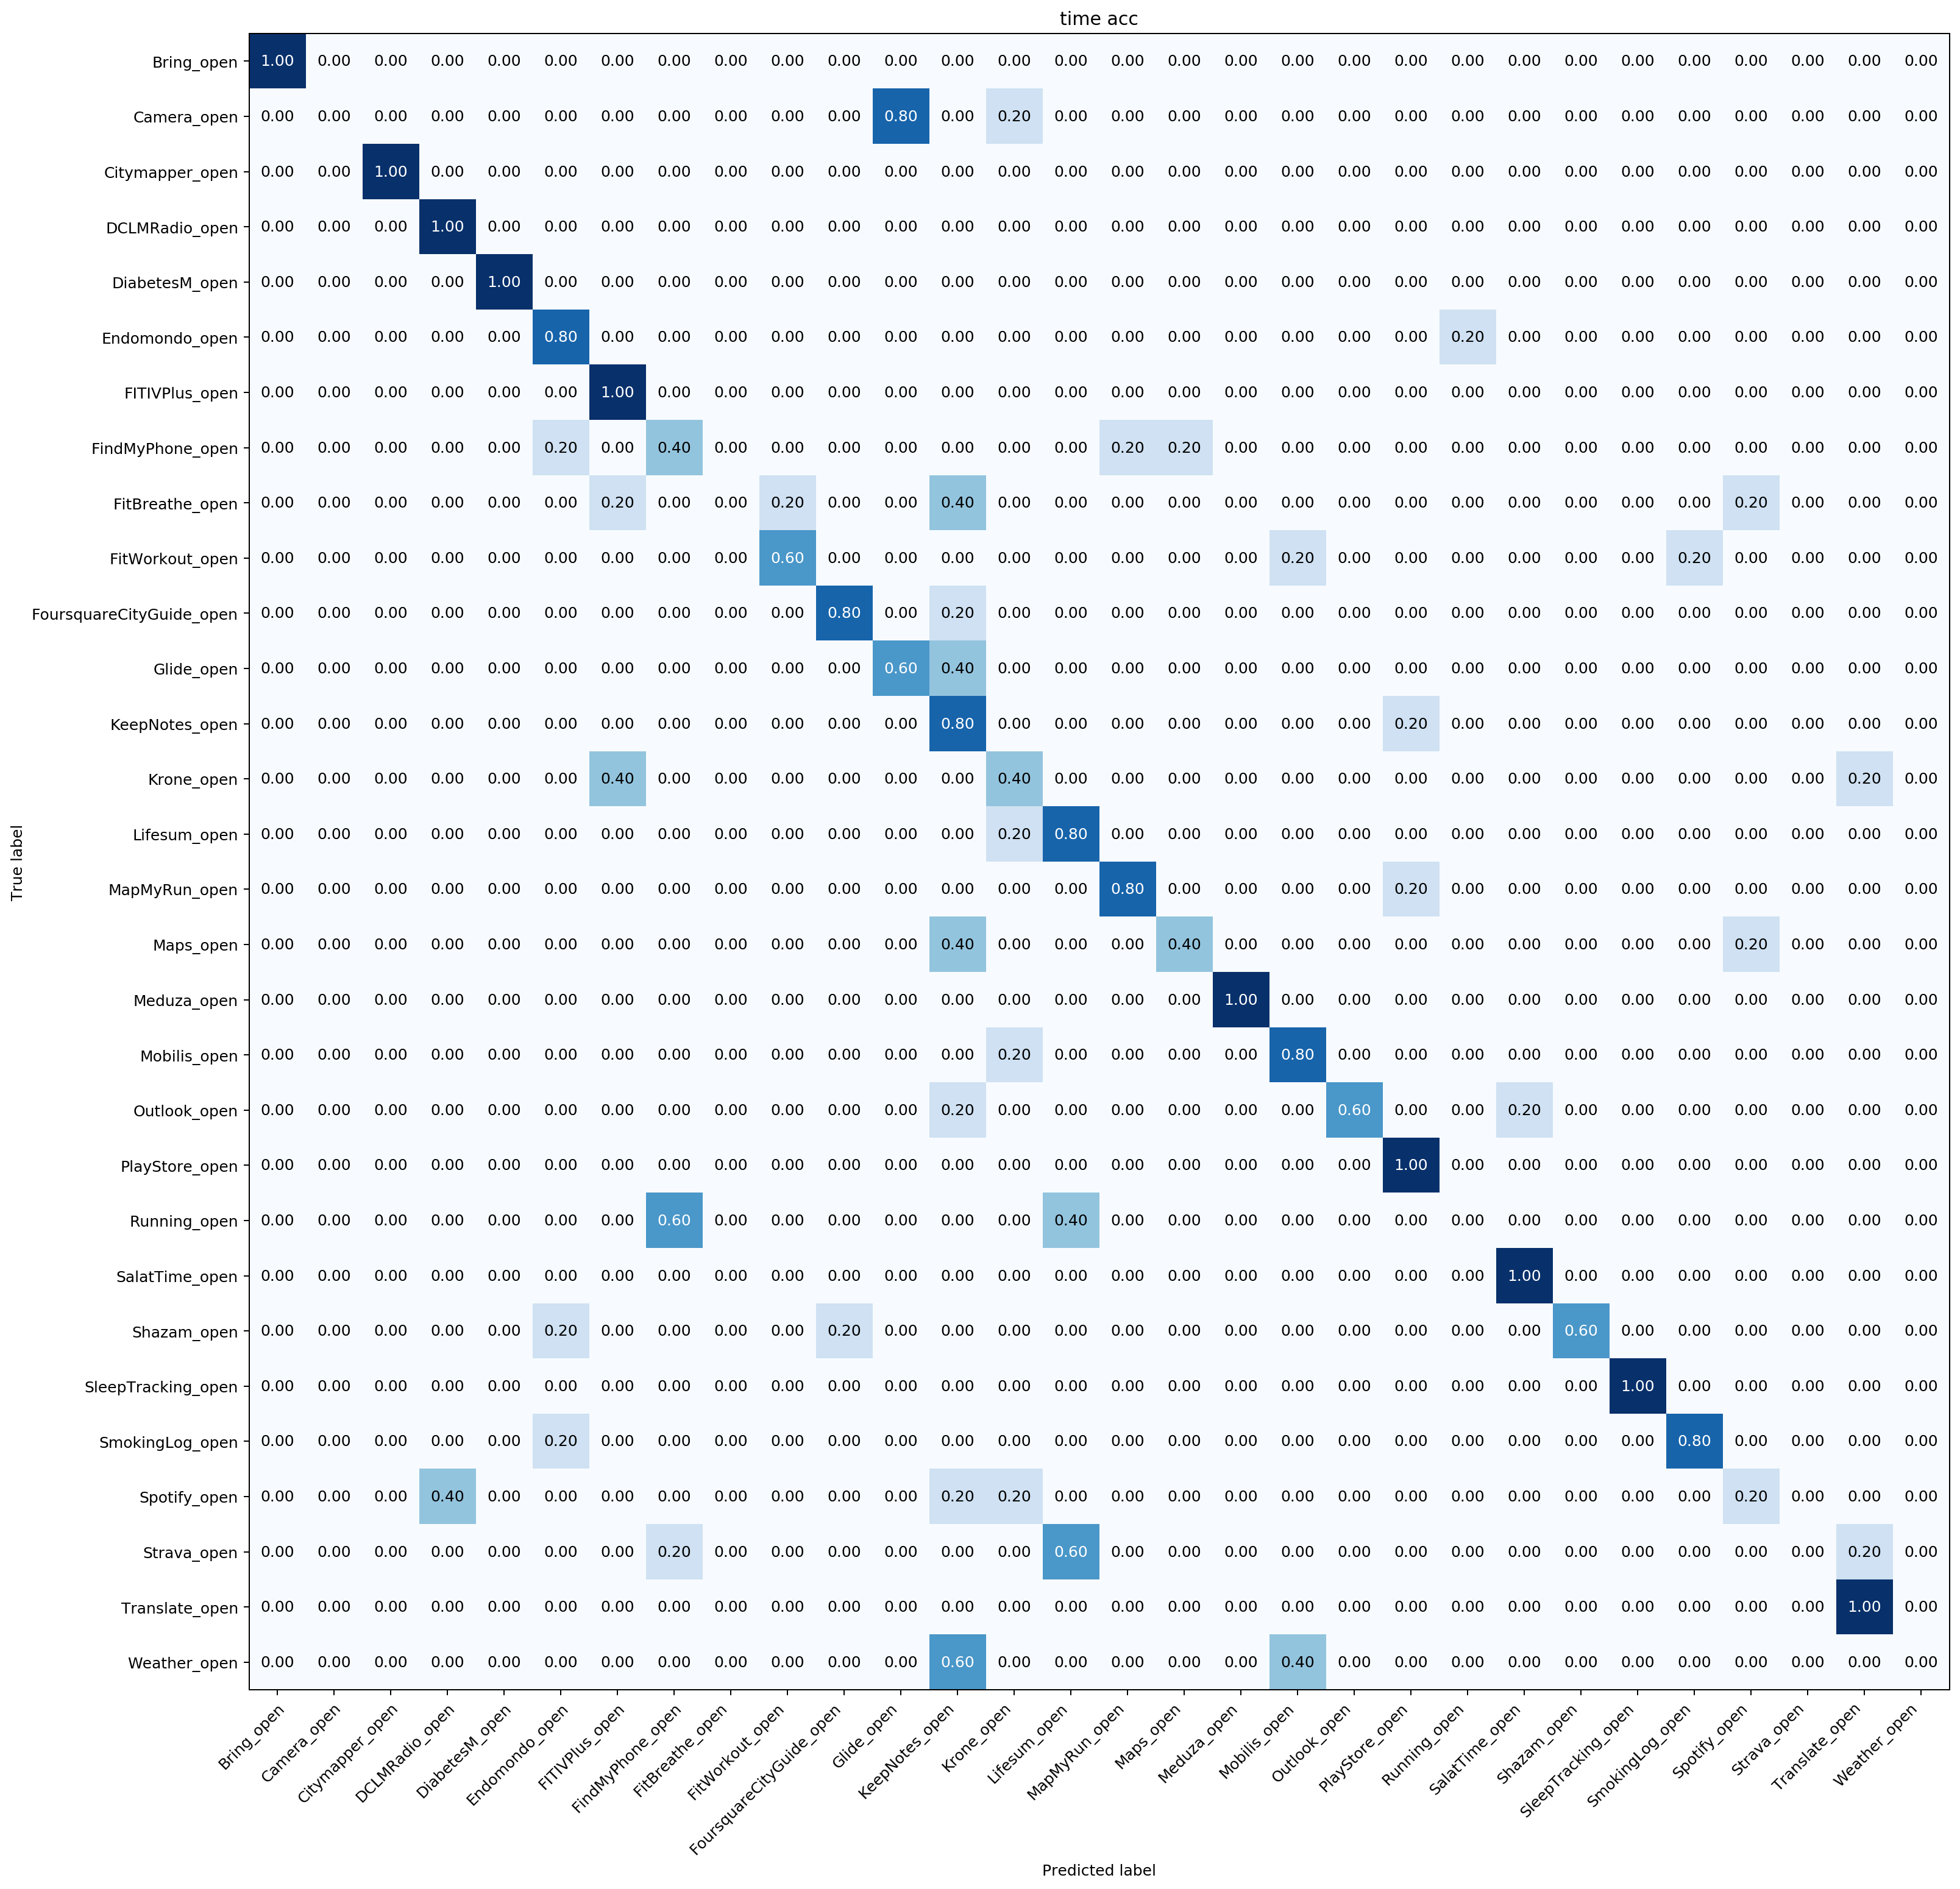

In [35]:
DATA_PATH_PAST = ["data/fossil/open-1/", "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DATA_PATH_NEW = ["data/huawei/open-5/"]
DISCARD_PAST = ["AppInTheAir_openNotLogin", "Calm_open", "Telegram_open", "ChinaDaily_open", "Fit_open", "Qardio_open", "WashPost_openConnectionError"]
DISCARD_NEW = ["WashPost_open", "AppInTheAir_open"]
X_past, y_past = evaluate(DATA_PATH_PAST, DISCARDED_ACTION=DISCARD_PAST, RETURN_FEATURES_AND_LABELS=True)
X_new, y_new = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARD_NEW, RETURN_FEATURES_AND_LABELS=True)



print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)

print("building and training a model for confusion matrix")
clf.fit(X_past, y_past)
y_new_pred = clf.predict(X_new)
accuracy = metrics.accuracy_score(y_new, y_new_pred)
print("accuracy = ", accuracy)
_ = plot_confusion_matrix(y_new, y_new_pred, title= "time acc", save = "time_acc", PLOT_DIR="./plots/")


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
Q-Explorist-HR: AppInTheAir_openNotLogin - 17
Q-Explorist-HR: Bring_open - 17
Q-Explorist-HR: Calm_open - 17
Q-Explorist-HR: ChinaDaily_open - 17
Q-Explorist-HR: Citymapper_open - 17
Q-Explorist-HR: DCLMRadio_open - 17
Q-Explorist-HR: DiabetesM_open - 17
Q-Explorist-HR: Endomondo_open - 17
Q-Explorist-HR: FITIVPlus_open - 17
Q-Explorist-HR: FindMyPhone_open - 17
Q-Explorist-HR: FitBreathe_open - 17
Q-Explorist-HR: FitWorkout_open - 17
Q-Explorist-HR: Fit_open - 17
Q-Explorist-HR: FoursquareCityGuide_open - 17
Q-Explorist-HR: Glide_open - 17
Q-Explorist-HR: KeepNotes_open - 17
Q-Explorist-HR: Krone_open - 17
Q-Explorist-HR: Lifesum_open - 17
Q-Explorist-HR: MapMyRun_open - 17
Q-Explorist-HR: Maps_open - 17
Q-Explorist-HR: Meduza_open - 17
Q-Explorist-HR: Mobilis_open - 17
Q-Explorist-HR: Outlook_open - 17
Q-Explorist-HR: PlayStore_open - 17
Q-Explorist-HR: Qardio_open - 17
Q-Explor

/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in true_divide


Saved image ./plots/Confusion_matrix_train_with_Huawei_test_with_Fossil_acc=40_79_.png


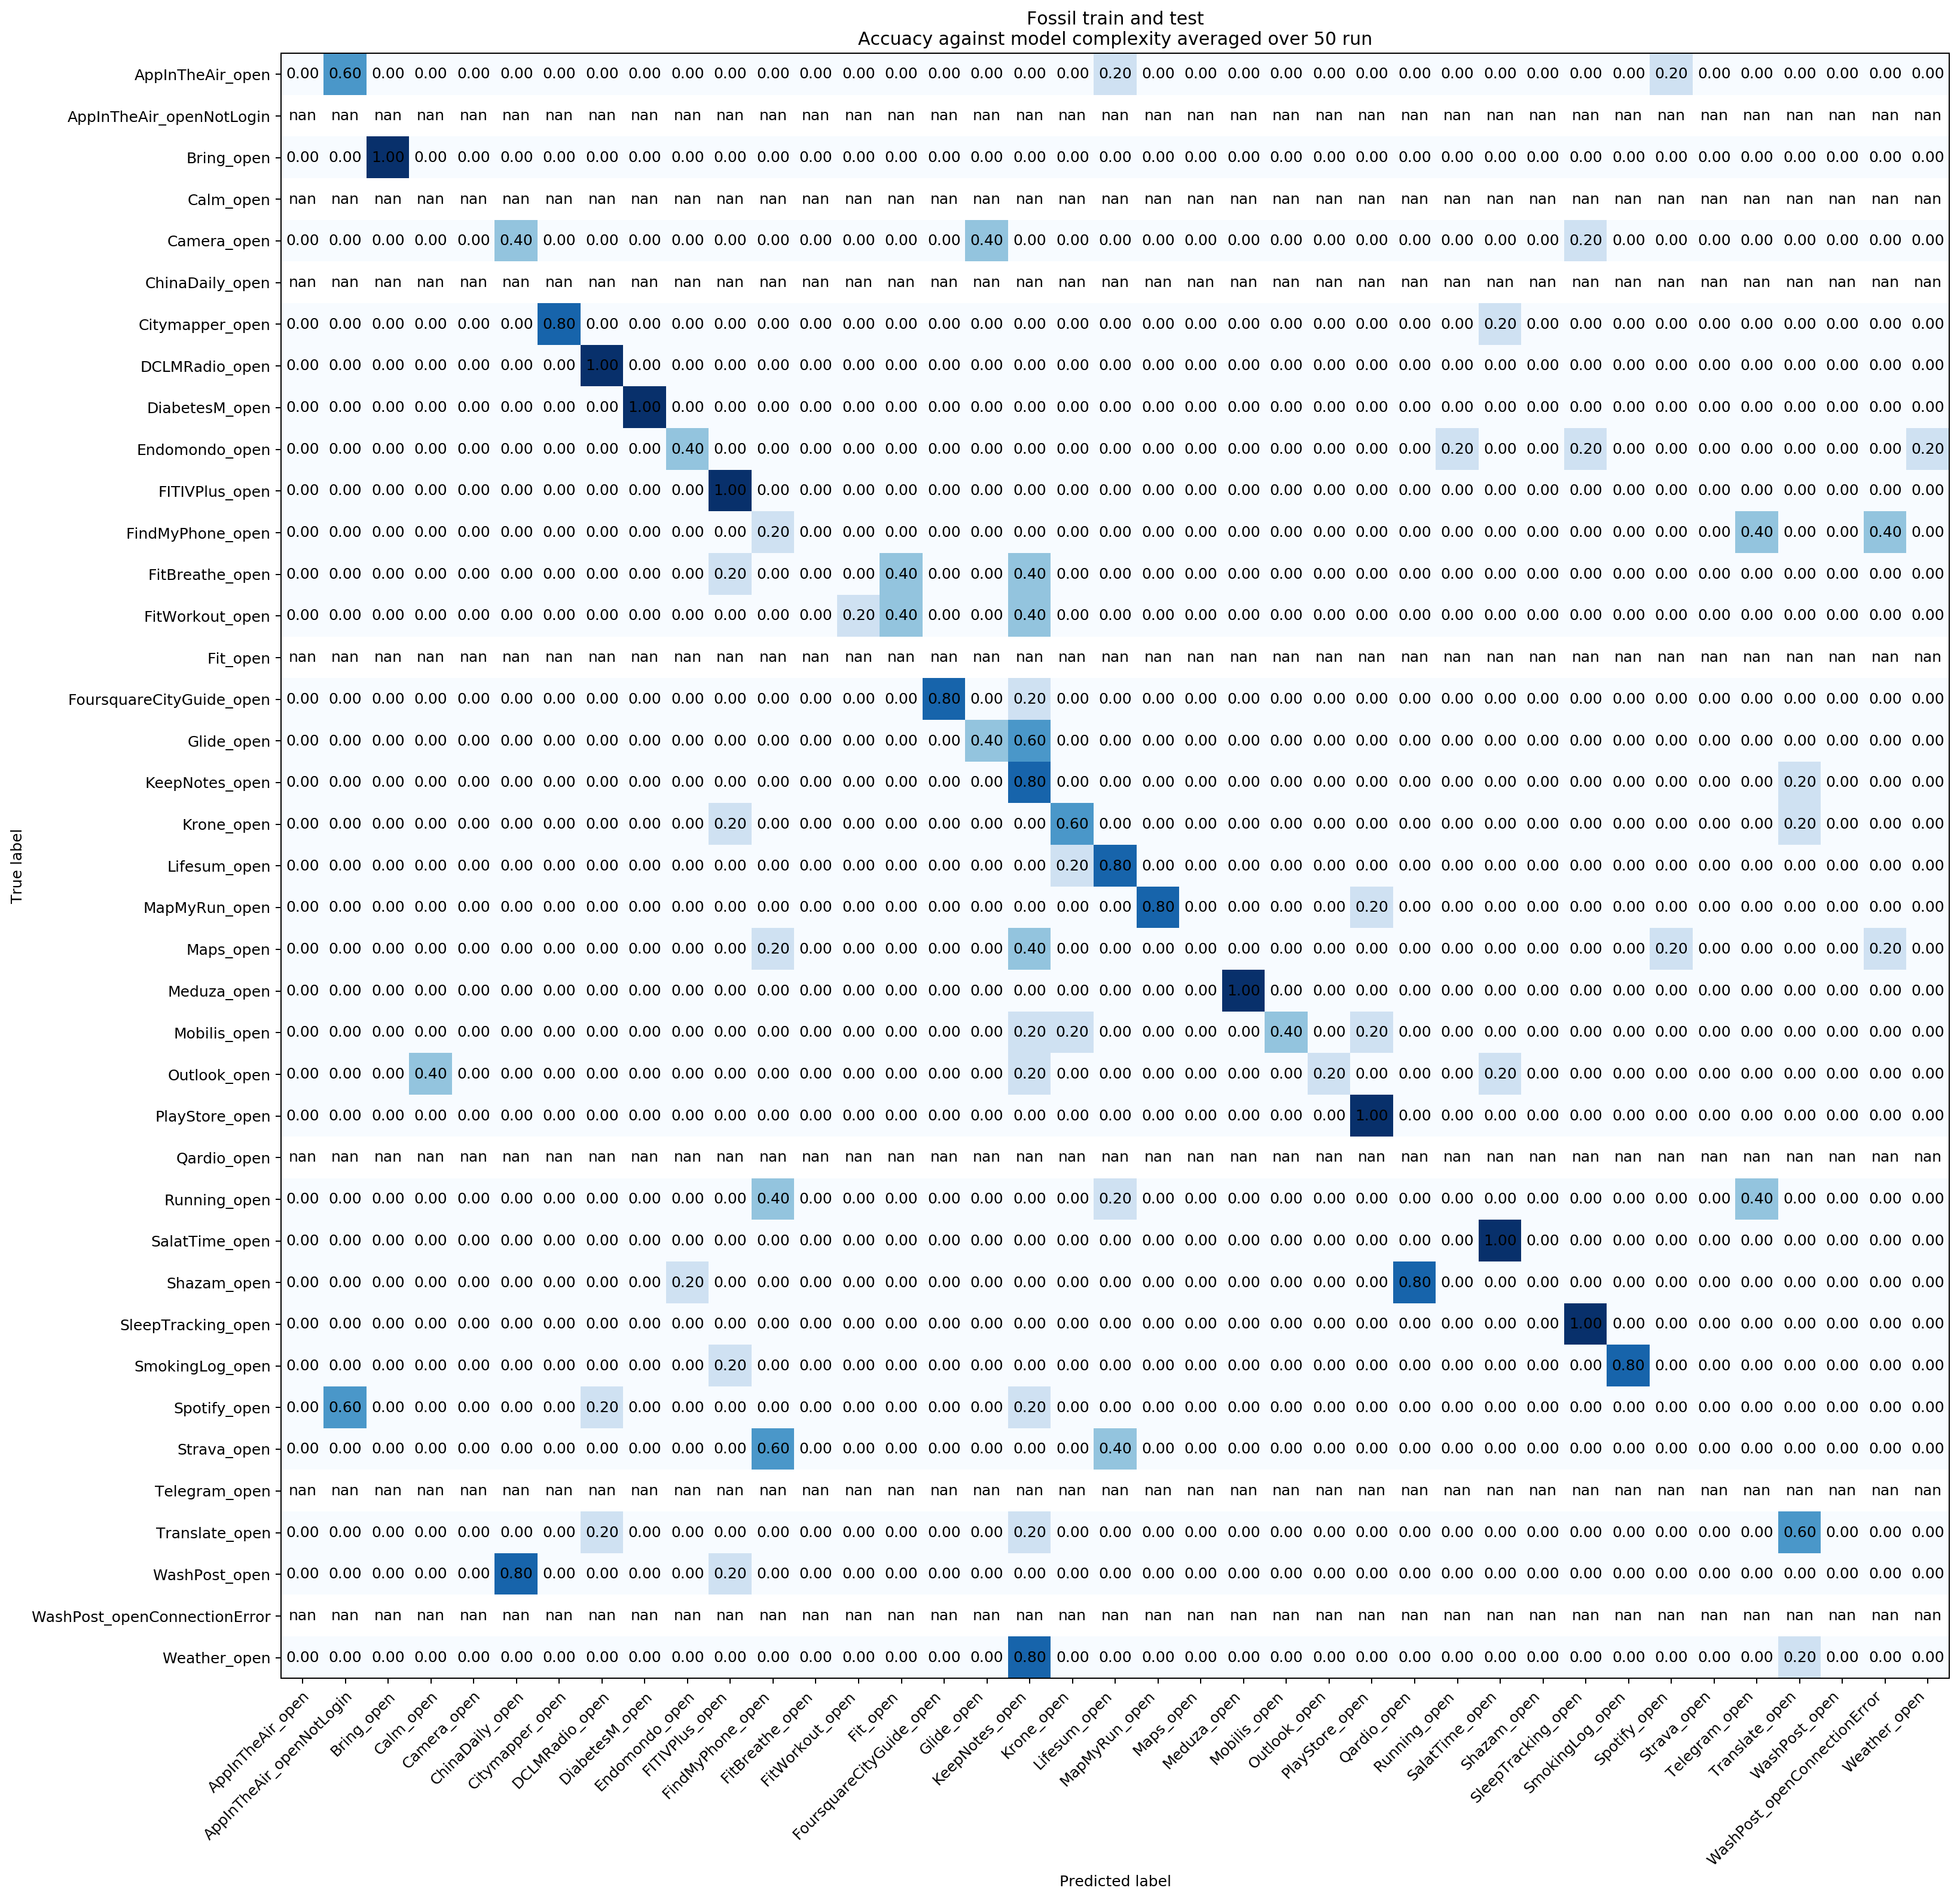

In [416]:
DATA_PATH = DATA_PATH = ["data/fossil/open-1/", "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all

DATA_PATH_HUAWEI_NEW = ["data/huawei/open-5/"]


print("\nimporting data...")
sources_files_past = find_sources(DATA_PATH_HUAWEI_PAST)
sources_files_new = find_sources(DATA_PATH_HUAWEI_NEW)


events_past, _ = cut_all_datasets_in_events(sources_files_past)
events_new, _ = cut_all_datasets_in_events(sources_files_new)

print("filtering app that does not send traffic by their length")
filtered_events_past = filter_by_length(events_past)
filtered_events_new = filter_by_length(events_new)


print("dataset equalization per class")
filtered_events_past, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events_past)
filtered_events_new, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events_new)

count_print(filtered_events_past)

print("building features and labels")
X_past, y_past = build_features_labels_dataset(filtered_events_past)
X_new, y_new = build_features_labels_dataset(filtered_events_new)


accuracies = []

print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)

print("building and training a model for confusion matrix")
clf.fit(X_past, y_past)
y_new_pred = clf.predict(X_new)
accuracy = metrics.accuracy_score(y_new, y_new_pred)
print("accuracy = ", accuracy)

_ = plot_confusion_matrix(y_new, y_new_pred, title= title, save = saved_title, PLOT_DIR="./plots/")

Hey, I found that when training with old huawei capture and test with new huawei capture I had  approximatively  results with the Fosill

(67% than with it's . So I investigate and found that some applications ). Example: Spotify was not paired. Apps are buggy in one watch but not in the other AppInTheAir, Apps requiring location on Fossil does not work. Apps that requires location does not work well on Nexus (sometimes it does that's why I am also confused). Also the settings I had to 

To confirm that: 

Improve previous results by capture both when location not found and location found. **Making the model more general by also including data when location is disabled**


Improve FN rate by adding a class missclassifed after having predicted the label. The criteria to put a label in the nocallfound class will be if the classifier has >50% confidence about this particular sample

##### Becarefull with outlook could not login on nexus

### Cleaning Fossil dataset (Slaver/Master swapping issues)
